In [133]:
cd /home/dsi/mbouchouia/code/git/PRIM/Notebooks/

/home/dsi/mbouchouia/code/git/PRIM/Notebooks


In [2]:

import tensorflow as tf

config = tf.ConfigProto(intra_op_parallelism_threads=70, 
                        inter_op_parallelism_threads=70,
                        allow_soft_placement=True,
                        log_device_placement=True
                       )

session = tf.Session(config=config,graph=tf.get_default_graph())

tf.keras.backend.set_session(session)


In [3]:
import sklearn
import itertools

In [4]:
from sklearn.metrics import r2_score

In [5]:
import numpy as np
import random
import sys
import io
import matplotlib.pyplot as plt
import urllib

In [6]:
import time
import sys
import pymongo
import os
sys.path.append('../scripts/')

import Plotting
import folium
import matplotlib
import osmMerger
import CustomUtils
import OsmProcessing
import pandas as pd
from   functools import reduce
import seaborn as sns
import models
sns.set()
results_path = "../images/model results/"
def saveFig():
    if not os.path.isdir(results_path+model_name):
        os.makedirs(results_path+model_name)
    print(results_path+model_name)
    plt.savefig(results_path+model_name+input(),dpi=300,bbox_inches='tight')

In [7]:
from importlib import reload

In [8]:
speeds = pd.read_pickle("../data/monthsSpeed__0.pckl")
counts = pd.read_pickle('../data/monthsCount__0.pckl')

speeds_05 = pd.read_pickle("../data/monthsSpeed__5.pckl")
counts_05 = pd.read_pickle('../data/monthsCount__5.pckl')

speeds_10 = pd.read_pickle("../data/monthsSpeed__10.pckl")
counts_10 = pd.read_pickle('../data/monthsCount__10.pckl')

In [9]:
mergeResults,segmentsMeta, mergedSegments= osmMerger.mergeSegments(minValidData = osmMerger.MIN_VALID_DATA, weights=np.array([100,1,1,1]),speedsMx=speeds)
mergeResults.to_pickle("../data/mergeResults.pckl")
segmentsMeta.to_pickle("../data/segmentsMeta.pckl")
mergedSegments.to_pickle("../data/mergedSegments.pckl")

Computing raw data : 
first time call or reset : starting counter
getting segments and meta :
time spent 28.7 s
getting speed matrix :
time spent 0.1 s
computing meta attributs and inversed index :
time spent 0.2 s
computing merging criteria :
time spent 56.1 s
start merging :
iter :  1  seg 1 :  1133  seg2 :  1131  inv seg2 :  1131  mean non null  0.41036350138741157
iter :  101  seg 1 :  1512  seg2 :  1529  inv seg2 :  1529  mean non null  0.4250616336387069
iter :  201  seg 1 :  591  seg2 :  594  inv seg2 :  594  mean non null  0.44380872630209106
iter :  301  seg 1 :  1011  seg2 :  1012  inv seg2 :  1012  mean non null  0.4583650029124894
iter :  401  seg 1 :  1628  seg2 :  1627  inv seg2 :  1627  mean non null  0.4555568629059593
iter :  501  seg 1 :  2144  seg2 :  2143  inv seg2 :  2143  mean non null  0.4601418230166938
iter :  601  seg 1 :  16  seg2 :  32  inv seg2 :  32  mean non null  0.4745059675445329
iter :  701  seg 1 :  1976  seg2 :  1977  inv seg2 :  1977  mean non null

In [8]:
mergeResults=pd.read_pickle("../data/mergeResults.pckl")
segmentsMeta=pd.read_pickle("../data/segmentsMeta.pckl")

mergedSegments=pd.read_pickle("../data/mergedSegments.pckl")

In [10]:
data_cleaner = models.DataCleaner(speeds,segmentsMeta,mergeResults,counts,0.80)


data_cleaner_05 = models.DataCleaner(speeds_05,segmentsMeta,mergeResults,counts_05,0.80)


data_cleaner_10 = models.DataCleaner(speeds_10,segmentsMeta,mergeResults,counts_10,0.80)

intersectIndexes= np.intersect1d(np.intersect1d(data_cleaner.data.index,data_cleaner_05.data.index),data_cleaner_10.data.index)

In [13]:
mergedIndex=pd.Series(data=segmentsMeta.loc[mergeResults]['segmentID'].values,index = segmentsMeta['segmentID'].values)
speedssegs = speeds
speedssegs = speedssegs.assign(newIndex =mergedIndex.reindex(speedssegs.index).values)
speedssegs = speedssegs[~speedssegs.newIndex.isna()]

naStats=speedssegs.groupby('newIndex').apply(lambda x : pd.Series([(x.isna().sum(axis=1)/x.columns.size).mean(),(x.isna().sum(axis=1)/x.columns.size).min(),len(x)],index=["mean","min","nSeg"])).reindex(intersectIndexes)

intersectIndexes= np.setdiff1d(np.intersect1d(np.intersect1d(data_cleaner.data.index,data_cleaner_05.data.index),data_cleaner_10.data.index),naStats[naStats['min']>0.4].index)

In [11]:
speedDF = data_cleaner.data.reindex(intersectIndexes)
data_cleaner.data=data_cleaner.data.reindex(intersectIndexes)
countDF = data_cleaner.counts.reindex(intersectIndexes)
data_cleaner.counts = data_cleaner.counts.reindex(intersectIndexes)

speedDF_05 = data_cleaner_05.data.reindex(intersectIndexes)
countDF_05 = data_cleaner_05.counts.reindex(intersectIndexes)
speedDF_10 = data_cleaner_10.data.reindex(intersectIndexes)
countDF_10 = data_cleaner_10.counts.reindex(intersectIndexes)


In [16]:
adjacency_matrix = OsmProcessing.getAdjacencyMatrix(segmentsMeta)
adjacency_matrix = OsmProcessing.addLevel(adjacency_matrix,1)
adjacency_matrix = OsmProcessing.mergeAdjacencyMatrix(adjacency_matrix, mergeResults,segmentsMeta)
adjacency_matrix = adjacency_matrix[speedDF.index].loc[speedDF.index]

In [13]:
def createMlpModel(loss,optimizer,nlayers,neuronsPerLayer,relu_output):

    model = tf.keras.models.Sequential()
    #layers
    model.add(tf.keras.layers.Flatten())
    for i in range(nlayers)  :    
        model.add(tf.keras.layers.Dense(neuronsPerLayer*(i+1)))
    model.add(tf.keras.layers.Dense(nSegments,name='out_layer'))
    if relu_output :
        model.add(tf.keras.layers.ReLU())
    model.compile(loss=loss, optimizer=optimizer)
    return model

def createStackedLstmModel(loss,optimizer,nlayers,neuronsPerLayer,relu_output):
    model = tf.keras.models.Sequential()
    #layers
    for i in range(nlayers)  :    
        model.add(tf.keras.layers.LSTM(neuronsPerLayer*(i+1),return_sequences=True))
    model.add(tf.keras.layers.LSTM(nSegments,name='out_layer'))
    if relu_output :
        model.add(tf.keras.layers.ReLU())
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [14]:
build_grid= {'optimizer':['Adam'],
              'nlayers':[0,1,3],
              'neuronsPerLayer':[64],
              'loss':['MSE','MAE'],
              'relu_output':[False]
             }

train_grid={
    "batch_size":[8,32,64], 
    "epochs":[100], 
    "validation_split":[0.5]
}

preprocess_grid={
    'scale_Max':[True],
    'scale_log':[False],
    'input_lag':[1,6],
    'output_lag':[1],
    'time_as_input':[True],
    "validation_split":[0.5]

}

def getParamsFromGrid(grid):
    return [dict(list(zip(list(grid.keys()),x ))) for x in list(itertools.product(*list(grid.values())))]

def grid_search(data,buildfunc,build_grid,train_grid,preprocess_grid):

    grid = list(itertools.product( getParamsFromGrid(build_grid),
                                   getParamsFromGrid(train_grid),
                                   getParamsFromGrid(preprocess_grid)
                                 )
               )
    
    losses=[]
    val_losses=[]
    mseLoss=[]
    mseValLoss=[]
    for build_param,train_param,preprocess_param in grid :
        print(build_param,train_param,preprocess_param)
        x,y = preprocessData(data,**preprocess_param)
        xtrain = x[:int(len(x)*(train_param['validation_split']))]
        xtest = x[int(len(x)*(train_param['validation_split'])):]
        ytrain = y.reshape(-1,nSegments)[:int(len(x)*(train_param['validation_split']))]
        ytest = y.reshape(-1,nSegments)[int(len(x)*(train_param['validation_split'])):]
        tf.keras.backend.clear_session()
        tf.keras.backend.set_session(tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=32, inter_op_parallelism_threads=32)))

        model=buildfunc(**build_param)
        model.fit(xtrain,ytrain.reshape(-1,nSegments),validation_data = (xtest,ytest), **train_param,verbose=0)
        
        losses.append(model.evaluate(xtrain,ytrain,verbose=0))
        val_losses.append(model.evaluate(xtest,ytest,verbose=0))
        
        mseLoss.append(mse(reversePreProcess(ytrain,**preprocess_param),reversePreProcess(model.predict(xtrain),**preprocess_param)))
        mseValLoss.append(mse(reversePreProcess(ytest,**preprocess_param),reversePreProcess(model.predict(xtest),**preprocess_param)))
        print(losses[-1],val_losses[-1],mseLoss[-1],mseValLoss[-1])
        
    resDF = pd.DataFrame(list(zip(grid,losses,val_losses,mseLoss,mseValLoss)),columns=['params','loss_value','val_loss_value','mseLoss','mseValLoss'])
    
    return  pd.concat([resDF.params.apply(lambda x : pd.Series({**x[0],**x[1],**x[2]})),resDF[['loss_value','val_loss_value','mseLoss','mseValLoss']]],axis=1)


In [15]:
# resMlpDF = grid_search(data,createMlpModel,build_grid,train_grid,preprocess_grid)

In [16]:
# resLstmDF.groupby("time_as_input")['mseLoss'].describe()

In [17]:
# resLstmDF = grid_search(data,createStackedLstmModel,build_grid,train_grid,preprocess_grid)

In [18]:
"""
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(100,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm, daytime_input])
    x=tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)   
    data_model.model.summary()
"""
def multiInputMultiOutputModelLstm():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 5, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 100)          339600      speed_input[0][0]                
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 102)          0           speed_lstm[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense_15 (Dense)                (None, 100)          10300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense_15[0][0]                   
        ==================================================================================================
        Total params: 425,448
        Trainable params: 425,448
        Non-trainable params: 0
        __________________________________________________________________________________________________

    """
    main_input = tf.keras.layers.Input(x_train.shape[1:], name="speed_input")
    lstm = tf.keras.layers.LSTM(100,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(nSegments,name="lstm_branch")(lstm)

    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm, daytime_input])
    x = tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    
#     x=tf.keras.layers.Dense( nSegments, activation = tf.keras.activations.sigmoid )( x)

    output_layer = tf.keras.layers.Dense(nSegments,name="Output")(x)
    
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer,lstm_branch] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse, optimizer=optimizer)
    data_model.model.summary()
    

In [19]:
def monoInputModelLstm():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 5, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 100)          339600      speed_input[0][0]                
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 102)          0           speed_lstm[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense_15 (Dense)                (None, 100)          10300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense_15[0][0]                   
        ==================================================================================================
        Total params: 425,448
        Trainable params: 425,448
        Non-trainable params: 0
        __________________________________________________________________________________________________

    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(300,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(300,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    x=tf.keras.layers.Dense( 300, activation = tf.keras.activations.sigmoid )( lstm_branch)
    x=tf.keras.layers.Dense( 300, activation = tf.keras.activations.sigmoid )(x)
    x=tf.keras.layers.Dense( 300, activation = tf.keras.activations.sigmoid )(x)
    output_layer = tf.keras.layers.Dense( nSegments,name="Output",use_bias=False )(x)
    
    
    data_model.model = tf.keras.Model(inputs = [main_input], outputs= [output_layer])
    
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse, optimizer=optimizer)
    data_model.model.summary()


In [20]:
def multiInputModelLstmWithLastQuarter():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 4, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 50)           159800      speed_input[0][0]                
        __________________________________________________________________________________________________
        last_quarter_speeds (Lambda)    (None, 748)          0           speed_input[0][0]                
        __________________________________________________________________________________________________
        lstm_branch (Dense)             (None, 100)          5100        speed_lstm[0][0]                 
        __________________________________________________________________________________________________
        MLP_branch (Dense)              (None, 100)          74900       last_quarter_speeds[0][0]        
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 202)          0           lstm_branch[0][0]                
                                                                         MLP_branch[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense (Dense)                   (None, 100)          20300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense[0][0]                      
        ==================================================================================================
        Total params: 335,648
        Trainable params: 335,648
        Non-trainable params: 0
        __________________________________________________________________________________________________
    
    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(200,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(200,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    lambda_slice_layer = tf.keras.layers.Lambda(lambda x : x[:,data_model.input_lag-1,:],name="last_quarter_speeds")(main_input)
    mlp_breanch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="MLP_branch")(lambda_slice_layer)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm_branch, mlp_breanch, daytime_input])
    x=tf.keras.layers.Dense( 200, activation = tf.keras.activations.sigmoid )( merge_layer)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)   
    

In [21]:
def multiInputModelLstmWithLastQuarter():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 4, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 50)           159800      speed_input[0][0]                
        __________________________________________________________________________________________________
        last_quarter_speeds (Lambda)    (None, 748)          0           speed_input[0][0]                
        __________________________________________________________________________________________________
        lstm_branch (Dense)             (None, 100)          5100        speed_lstm[0][0]                 
        __________________________________________________________________________________________________
        MLP_branch (Dense)              (None, 100)          74900       last_quarter_speeds[0][0]        
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 202)          0           lstm_branch[0][0]                
                                                                         MLP_branch[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense (Dense)                   (None, 100)          20300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense[0][0]                      
        ==================================================================================================
        Total params: 335,648
        Trainable params: 335,648
        Non-trainable params: 0
        __________________________________________________________________________________________________
    
    """
    
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(250,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(250,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    
    lambda_slice_layer = tf.keras.layers.Lambda(lambda x : x[:,data_model.input_lag-1,:],name="last_quarter_speeds")(main_input)
    mlp_breanch = tf.keras.layers.Dense(250,activation= tf.keras.activations.sigmoid,name="MLP_branch")(lambda_slice_layer)
    
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm_branch, mlp_breanch, daytime_input])
    
    x=tf.keras.layers.Dense( 250, activation = tf.keras.activations.sigmoid )( merge_layer)
    x=tf.keras.layers.Dense( 250, activation = tf.keras.activations.sigmoid )(x)

    output_layer = tf.keras.layers.Dense(nSegments,name="Output", activation = tf.keras.activations.tanh  , use_bias=False)(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mae , optimizer=optimizer)   
    

In [22]:
def multiInputModelMLP():
    """
    __________________________________________________________________________________________________
    Layer (type)                    Output Shape         Param #     Connected to                     
    ==================================================================================================
    speed_input (InputLayer)        (None, 4, 748)       0                                            
    __________________________________________________________________________________________________
    flatten_multi_speed (Flatten)   (None, 2992)         0           speed_input[0][0]                
    __________________________________________________________________________________________________
    full_speed_mpl (Dense)          (None, 100)          299300      flatten_multi_speed[0][0]        
    __________________________________________________________________________________________________
    last_quarter_speeds (Lambda)    (None, 748)          0           speed_input[0][0]                
    __________________________________________________________________________________________________
    full_mlp_branch (Dense)         (None, 100)          10100       full_speed_mpl[0][0]             
    __________________________________________________________________________________________________
    slice_MLP_branch (Dense)        (None, 100)          74900       last_quarter_speeds[0][0]        
    __________________________________________________________________________________________________
    day_time_input (InputLayer)     (None, 2)            0                                            
    __________________________________________________________________________________________________
    Merge (Concatenate)             (None, 202)          0           full_mlp_branch[0][0]            
                                                                     slice_MLP_branch[0][0]           
                                                                     day_time_input[0][0]             
    __________________________________________________________________________________________________
    dense (Dense)                   (None, 100)          20300       Merge[0][0]                      
    __________________________________________________________________________________________________
    Output (Dense)                  (None, 748)          75548       dense[0][0]                      
    ==================================================================================================
    Total params: 480,148
    Trainable params: 480,148
    Non-trainable params: 0
    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    flatten_layer = tf.keras.layers.Flatten(name="flatten_multi_speed")(main_input)
    mlp=tf.keras.layers.Dense(100,name="full_speed_mpl")(flatten_layer)
    
    mlp = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="full_mlp_branch")(mlp)
    
    lambda_slice_layer = tf.keras.layers.Lambda(lambda x : x[:,data_model.input_lag-1,:],name="last_quarter_speeds")(main_input)
    mlp_breanch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="slice_MLP_branch")(lambda_slice_layer)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([mlp, mlp_breanch, daytime_input])
    x=tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)

In [23]:
def monoInputModelMLP():
    """
    __________________________________________________________________________________________________
    Layer (type)                    Output Shape         Param #     Connected to                     
    ==================================================================================================
    speed_input (InputLayer)        (None, 4, 748)       0                                            
    __________________________________________________________________________________________________
    flatten_multi_speed (Flatten)   (None, 2992)         0           speed_input[0][0]                
    __________________________________________________________________________________________________
    full_speed_mpl (Dense)          (None, 100)          299300      flatten_multi_speed[0][0]        
    __________________________________________________________________________________________________
    last_quarter_speeds (Lambda)    (None, 748)          0           speed_input[0][0]                
    __________________________________________________________________________________________________
    full_mlp_branch (Dense)         (None, 100)          10100       full_speed_mpl[0][0]             
    __________________________________________________________________________________________________
    slice_MLP_branch (Dense)        (None, 100)          74900       last_quarter_speeds[0][0]        
    __________________________________________________________________________________________________
    day_time_input (InputLayer)     (None, 2)            0                                            
    __________________________________________________________________________________________________
    Merge (Concatenate)             (None, 202)          0           full_mlp_branch[0][0]            
                                                                     slice_MLP_branch[0][0]           
                                                                     day_time_input[0][0]             
    __________________________________________________________________________________________________
    dense (Dense)                   (None, 100)          20300       Merge[0][0]                      
    __________________________________________________________________________________________________
    Output (Dense)                  (None, 748)          75548       dense[0][0]                      
    ==================================================================================================
    Total params: 480,148
    Trainable params: 480,148
    Non-trainable params: 0
    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    flatten_layer = tf.keras.layers.Flatten(name="flatten_multi_speed")(main_input)
    mlp = tf.keras.layers.Dense(350,name="full_speed_mpl")(flatten_layer)
    
    mlp = tf.keras.layers.Dense(350,activation= tf.keras.activations.sigmoid,name="full_mlp_branch")(mlp)
    
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([mlp, daytime_input])
    
    x=tf.keras.layers.Dense( 350, activation = tf.keras.activations.sigmoid )( merge_layer)
    x=tf.keras.layers.Dropout(0.5)(x)
    x=tf.keras.layers.Dense( 350, activation = tf.keras.activations.sigmoid )( x)
    x=tf.keras.layers.Dropout(0.5)(x)

    x=tf.keras.layers.Dense( 350, activation = tf.keras.activations.sigmoid )( x)

    output_layer = tf.keras.layers.Dense(nSegments,name="Output", activation = tf.keras.activations.tanh , use_bias=False)(x)
    
    
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)

In [24]:
def mlp():
    main_input = tf.keras.layers.Input(x_train.shape[1:], name="speed_input")

    flat = tf.keras.layers.Flatten()(main_input)
    
    dense=tf.keras.layers.Dense(nSegments,activation='sigmoid')(flat)

    # densePReLU = tf.keras.layers.PReLU(alpha_initializer="zeros")(dense)
    
    #     lstm=tf.keras.layers.Dense(250,activation= tf.keras.activations.sigmoid)(lstm)

    dense = tf.keras.layers.Dropout(0.7)(dense)
    dense=tf.keras.layers.Dense(nSegments,activation='sigmoid')(dense)
#     densePReLU = tf.keras.layers.PReLU(alpha_initializer="zeros")(dense)

    output_layer = tf.keras.layers.Dense(nSegments,name="Output")(dense)
    data_model.model = tf.keras.Model(inputs = [main_input], outputs= [output_layer])

    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse, optimizer=optimizer)
    data_model.model.summary()

In [25]:
def statefullLstm():
    main_input = tf.keras.layers.Input(x_train.shape[1:],batch_size=batch_size,name="speed_input")

    lstm=tf.keras.layers.LSTM(nSegments,name="speed_lstm",stateful="true")(main_input)

    lstm_branch = tf.keras.layers.Dense(nSegments,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)


    x=tf.keras.layers.Dense( nSegments, activation = tf.keras.activations.sigmoid )( lstm_branch)
    # x=tf.keras.layers.Dense( 350, activation = tf.keras.activations.sigmoid )( x)


    output_layer = tf.keras.layers.Dense(nSegments,name="Output")(x)

    data_model.model = tf.keras.Model(inputs = [main_input], outputs= [output_layer])

    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse, optimizer=optimizer)
    data_model.model.summary()


In [26]:

"""
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(100,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm, daytime_input])
    x=tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)   
    data_model.model.summary()
"""

def multiInputModelLstm():
    """
            __________________________________________________________________________________________________
            Layer (type)                    Output Shape         Param #     Connected to                     
            ==================================================================================================
            speed_input (InputLayer)        (None, 5, 748)       0                                            
            __________________________________________________________________________________________________
            speed_lstm (LSTM)               (None, 100)          339600      speed_input[0][0]                
            __________________________________________________________________________________________________
            day_time_input (InputLayer)     (None, 2)            0                                            
            __________________________________________________________________________________________________
            Merge (Concatenate)             (None, 102)          0           speed_lstm[0][0]                 
                                                                             day_time_input[0][0]             
            __________________________________________________________________________________________________
            dense_15 (Dense)                (None, 100)          10300       Merge[0][0]                      
            __________________________________________________________________________________________________
            Output (Dense)                  (None, 748)          75548       dense_15[0][0]                   
            ==================================================================================================
            Total params: 425,448
            Trainable params: 425,448
            Non-trainable params: 0
            __________________________________________________________________________________________________

    """
    main_input = tf.keras.layers.Input(x_train.shape[1:], name="speed_input")
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:], name="day_time_input")

    lstm=tf.keras.layers.LSTM(nSegments, name="speed_lstm")(main_input)
    
    lstm_branch = tf.keras.layers.Dense(nSegments, activation= tf.keras.activations.relu, name="lstm_branch")(lstm)
    
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm_branch, daytime_input])
    
    x=tf.keras.layers.Dense( nSegments, activation = tf.keras.activations.relu )( merge_layer)


    output_layer = tf.keras.layers.Dense(nSegments, name="Output")(x)
    
    
    data_model.model = tf.keras.Model(inputs = [main_input, daytime_input], outputs= [output_layer])
    
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse, optimizer=optimizer, metrics=['mse'])
    data_model.model.summary()


In [27]:
"""
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(100,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm, daytime_input])
    x=tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)   
    data_model.model.summary()
"""

def bnActivationDropout(x,units,act,drp,bn=False):
    x=tf.keras.layers.Dense( units)(x)
    if bn:
        x = tf.keras.layers.BatchNormalization()(x)
    x= tf.keras.layers.Activation(act)(x)
    x =tf.keras.layers.Dropout(drp)(x)
    return x


def simpleMultiInputModelLstm():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 5, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 100)          339600      speed_input[0][0]                
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 102)          0           speed_lstm[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense_15 (Dense)                (None, 100)          10300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense_15[0][0]                   
        ==================================================================================================
        Total params: 425,448
        Trainable params: 425,448
        Non-trainable params: 0
        __________________________________________________________________________________________________

    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    
    lstm=tf.keras.layers.LSTM(350,name="speed_lstm")(main_input)

    x = bnActivationDropout(lstm,350,"tanh",0.2)
    x = bnActivationDropout(x,350,"tanh",0.2)
    x = bnActivationDropout(x,350,"tanh",0)

    
    
    
    output_layer = tf.keras.layers.Dense(nSegments,name="Output")(x)
    
    
    data_model.model = tf.keras.Model(inputs = [main_input], outputs= [output_layer])
    
    optimizer = tf.keras.optimizers.Adam()
    
    data_model.model.compile(loss=smape_loss, optimizer=optimizer,metrics=['mse',coeff_determination])

    data_model.model.summary()


In [28]:
def B1(n_units=300):
    "[['flatten', 'dense'], [300, 300], ['flatten', 'dense'], [300, 300], ['dense', 'dense'], [300, 300]]_20"
    main_input = tf.keras.layers.Input( x_train.shape[1:], name="speed_input")
    count_input = tf.keras.layers.Input( count_train.shape[1:], name="count_input")
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    
    speed_layer = tf.keras.layers.Flatten()(main_input)
    speed_layer = tf.keras.layers.Dense(nSegments,activation="sigmoid")(speed_layer)
    
    count_layer = tf.keras.layers.Flatten()(count_input)
    count_layer = tf.keras.layers.Dense(nSegments,activation="sigmoid")(count_layer)
    
    layer = tf.keras.layers.Concatenate(1,name="count_speed_merge")([speed_layer, count_layer,daytime_input])
    
    layer = tf.keras.layers.Dense(n_units,activation="sigmoid")(layer)
    layer = tf.keras.layers.Dense(n_units,activation="sigmoid")(layer)

    output_layer = tf.keras.layers.Dense(nSegments,name="Output")(layer)
    output_layer = tf.keras.layers.PReLU(alpha_initializer="ones",alpha_regularizer=tf.keras.regularizers.l1(0.001))(output_layer)

    model =tf.keras.Model(inputs = [main_input,count_input,daytime_input], outputs= [output_layer])

    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss=smape_loss, optimizer=optimizer,metrics=["mse"])
    data_model.model =model
    mlpModel=data_model
    model.summary()

In [29]:
def separateDepthWiseLstmPerDay(hist_layer):

    n_convs = hist_layer.shape[1]//20
    conv_layers=[]
    for i in range(n_convs) :
        conv_layers.append(tf.keras.layers.Lambda(lambda x : x[:,i*20:(i+1)*20,:],name="historical_conv_"+str(i))(hist_layer))
        conv_layers[i]= tf.keras.layers.LSTM(200, name="LSTM_"+str(i) )(conv_layers[i])
        conv_layers[i] = tf.keras.layers.Reshape((1,conv_layers[i].shape[1]))(conv_layers[i])

    conv_layer = tf.keras.layers.Concatenate(1,name="hist_lstm_layers_concat")(conv_layers)
    return conv_layer


def separateDepthWiseConvPerDay(hist_layer):
    hist_layer = tf.keras.layers.Reshape((hist_layer.shape[1],1,hist_layer.shape[2]))(hist_layer)

    n_convs = hist_layer.shape[1]//20
    conv_layers=[]
    for i in range(n_convs) :
        conv_layers.append(tf.keras.layers.Lambda(lambda x : x[:,i*20:(i+1)*20,:],name="historical_conv_"+str(i))(hist_layer))
        conv_layers[i] = tf.keras.layers.DepthwiseConv2D((20,1),depth_multiplier = 1,name="conv1D_"+str(i),activation="tanh")(conv_layers[i])
        conv_layers[i] = tf.keras.layers.Reshape((conv_layers[i].shape[1],conv_layers[i].shape[3]))(conv_layers[i])
    
    conv_layer = tf.keras.layers.Concatenate(1,name="conv_layers_concat")(conv_layers)
    return conv_layer

def convMultiInputModelLstm():
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    
    historical_speeds_layer = tf.keras.layers.Lambda(lambda x : x[:,:-(data_model.input_lag%20),:],name="historical_speeds")(main_input)
    
    historical_speeds_layer = separateDepthWiseLstmPerDay(historical_speeds_layer)
    historical_speeds_layer = tf.keras.layers.LSTM(200, name="speed_hist_lstm")(historical_speeds_layer)
    
    historical_speeds_layer = bnActivationDropout( historical_speeds_layer,200,"tanh",0)
    
    
    
    local_speeds_layer = tf.keras.layers.Lambda(lambda x : x[:, -(data_model.input_lag%20):, :],name="local_speeds")(main_input)
    local_speeds_layer = tf.keras.layers.LSTM(200, name="speed_local_lstm")(local_speeds_layer)

    local_speeds_layer = bnActivationDropout(local_speeds_layer, 200, "tanh", 0)

    speed_merge = tf.keras.layers.Concatenate(1, name="speed_merge")([local_speeds_layer, historical_speeds_layer])

    
    x = bnActivationDropout(speed_merge, 200, "tanh",0.25)
    x = bnActivationDropout(x, 200, "tanh", 0)

    
    
    
    output_layer = tf.keras.layers.Dense(nSegments,name="Output")(x)

    data_model.model = tf.keras.Model(inputs = [main_input], outputs= [output_layer])
    
    optimizer = tf.keras.optimizers.Adam(0.0012)
    
    data_model.model.compile(loss=smape_loss, optimizer=optimizer, metrics=['mse',smape_loss])

    data_model.model.summary()

    

def convMultiInputModelMLP():
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    
    historical_speeds_layer = tf.keras.layers.Lambda(lambda x : x[:,:-(data_model.input_lag%20),:],name="historical_speeds")(main_input)
    
    historical_speeds_layer = separateDepthWiseConvPerDay(historical_speeds_layer)
    historical_speeds_layer =tf.keras.layers.Flatten()(historical_speeds_layer)
    historical_speeds_layer = bnActivationDropout( historical_speeds_layer,300,"tanh",0.2 )
    
    
    
    
    local_speeds_layer = tf.keras.layers.Lambda(lambda x : x[:, -(data_model.input_lag%20):, :],name="local_speeds")(main_input)
    local_speeds_layer =tf.keras.layers.Flatten()(local_speeds_layer)


    local_speeds_layer = bnActivationDropout(local_speeds_layer, 300, "tanh", 0.2)

    speed_merge = tf.keras.layers.Concatenate(1, name="speed_merge")([local_speeds_layer, historical_speeds_layer])

    
    x = bnActivationDropout(speed_merge, 300, "tanh",0.2)
    x = bnActivationDropout(x, 300, "tanh", 0)

    
    
    
    output_layer = tf.keras.layers.Dense(nSegments,name="Output")(x)

    data_model.model = tf.keras.Model(inputs = [main_input], outputs= [output_layer])
    
    optimizer = tf.keras.optimizers.Adam()
    
    data_model.model.compile(loss=smape_loss, optimizer=optimizer, metrics=['mse',smape_loss])

    data_model.model.summary()


In [30]:
def countInputModelLstm():
    main_input = tf.keras.layers.Input( x_train.shape[1:], name="speed_input")
    count_input = tf.keras.layers.Input( count_train.shape[1:], name="count_input")
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")

    
    count_lstm=tf.keras.layers.LSTM( 350, name="count_lstm")( count_input )
    
#     count_lstm=bnActivationDropout(count_lstm,350,"tanh",0.2)

    lstm=tf.keras.layers.LSTM(350, name="speed_lstm")( main_input)

#     lstm=bnActivationDropout(lstm,350,"tanh",0.2)

    
    count_speed_merge = tf.keras.layers.Concatenate(1,name="count_speed_merge")([count_lstm, lstm])

    
    x = bnActivationDropout(count_speed_merge,350,"tanh",0.2)

    x = tf.keras.layers.Concatenate(1,name="time_input_concat")([daytime_input,x])

    x = bnActivationDropout(x,350,"tanh",0)


    output_layer = tf.keras.layers.Dense(nSegments*output_lag,name="Output")(x)
    
    data_model.model = tf.keras.Model(inputs = [main_input,count_input,daytime_input], outputs= [output_layer])

    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=smape_loss, optimizer=optimizer,metrics=["mse"])
    data_model.model.summary()

In [31]:
K = tf.keras.backend

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred -y_true)))

def smape_loss(true, predicted):
    """
    Differentiable SMAPE loss
    :param true: Truth values
    :param predicted: Predicted values
    :param weights: Weights mask to exclude some values
    :return:
    """
    epsilon = 0.1 # Smoothing factor, helps SMAPE to be well-behaved near zero
#     true_o = tf.expm1(true)
#     pred_o = tf.expm1(predicted)
    true_o = true
    pred_o = predicted
    summ  = tf.maximum(tf.abs(true_o) + tf.abs(pred_o) + epsilon, 0.5+ epsilon)
    smape = tf.abs(pred_o - true_o) / summ * 2.0
    return smape

# def smape_loss(y_true, y_pred):

#     summ = tf.abs(y_true) + tf.abs(y_pred)
#     smape = tf.abs(y_pred - y_true) / summ * 2.0
#     return smape



def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return -( 1 - SS_res/(SS_tot + K.epsilon()) )

nSegments = len(speedDF)
input_lag, output_lag, sequence_length =3, 1, 20#speedDF.columns.size
valid_split = 0.7
model_name ="LSTM timed shift mean max scale"

params        = {"scale_max":True, "scale_output":True}
data_model    = models.DataModel( speedDF,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params )
data_model_05 = models.DataModel( speedDF_05, input_lag, output_lag, sequence_length, valid_split = valid_split, **params )
data_model_10 = models.DataModel( speedDF_10, input_lag, output_lag, sequence_length, valid_split = valid_split, **params )                                                                  

data_model.preprocessData()
data_model_05.preprocessData()
data_model_10.preprocessData()

x_train_00, y_train_00, x_test_00, y_test_00 = data_model.trainSplit()
x_train_05, y_train_05, x_test_05, y_test_05 = data_model.trainSplit()
x_train_10, y_train_10, x_test_10, y_test_10 = data_model.trainSplit()

x_train = np.concatenate([x_train_00,x_train_05,x_train_10])
y_train = np.concatenate([y_train_00,y_train_05,y_train_10])

count_data = models.DataModel( countDF, input_lag, output_lag, sequence_length, valid_split = valid_split)
count_train_00, _, count_test_00, _ = count_data.trainSplit()


count_data_05 = models.DataModel( countDF_05, input_lag, output_lag, sequence_length, valid_split = valid_split)
count_train_05, _, count_test_05, _ = count_data.trainSplit()

count_data_10 = models.DataModel( countDF_10, input_lag, output_lag, sequence_length, valid_split = valid_split)
count_train_10, _, count_test_10, _ = count_data.trainSplit()

count_train =  np.concatenate([ count_train_00,
                                count_train_05,
                                count_train_10
                              ]
                             )


data_model.count_data = count_data

data_model.time_data=  data_model.getDaysTypes()

train_days_00, test_days_00 =  data_model.getDaysTypes()
train_days_05, _ = data_model_05.getDaysTypes()
train_days_10, _ = data_model_10.getDaysTypes()

train_days= np.concatenate([train_days_00,train_days_05,train_days_10])

tf.keras.backend.clear_session()

config = tf.ConfigProto(intra_op_parallelism_threads=10, 
                        inter_op_parallelism_threads=10,
                        allow_soft_placement=True, 
                        log_device_placement=True
                       )
session = tf.Session(config=config,graph=tf.get_default_graph())

tf.keras.backend.set_session(session)

B1()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
speed_input (InputLayer)        (None, 3, 548)       0                                            
__________________________________________________________________________________________________
count_input (InputLayer)        (None, 3, 548)       0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1644)         0           speed_input[0][0]                
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 1644)         0           count_input[0][0]                
_____________________________________

In [32]:
print(data_model.mae(data_model.predict('train', y_step=0),y_train_00,y_step=0), data_model.mae(data_model.predict('test',y_step=0),y_test_00,y_step=0))
# print(data_model.mae(data_model.predict('train',y_step=1),y_train_00,y_step=1), data_model.mae(data_model.predict('test',y_step=1),y_test_00,y_step=1))
# print(data_model.mae(data_model.predict('train',y_step=2),y_train_00,y_step=2), data_model.mae(data_model.predict('test',y_step=2),y_test_00,y_step=2))

74.6746922814805 75.4289987993814


In [33]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor=0.9,verbose=1,
                              patience=5, min_lr=0.0001,cooldown=5)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,restore_best_weights=True)

batch_size = 15
print(data_model.model.summary())
# modelHist = data_model.model.fit([x_train_00],[y_train_00],validation_data=([x_test_00],[y_test_00]),batch_size=batch_size,epochs=200,callbacks=[reduce_lr,early_stop])
# modelHist = data_model.model.fit([x_train_00,train_days_00],[y_train_00],validation_data=([x_test_00,test_days_00],y_test_00),batch_size=batch_size,epochs=200,callbacks=[reduce_lr,early_stop])
modelHist = data_model.model.fit([x_train_00, count_train_00, train_days_00], [y_train_00], validation_data=([x_test_00,count_test_00,test_days_00],y_test_00), batch_size=batch_size,epochs=400,callbacks=[reduce_lr,early_stop])
# modelHist = data_model.model.fit([x_train,count_train,train_days],[y_train],validation_data=([x_test_00, count_test_00, test_days_00],y_test_00), batch_size=batch_size, epochs=200,callbacks=[reduce_lr, early_stop])

# for i in range(40):

#     modelHist = data_model.model.fit([x_train,count_train,train_days],[y_train],validation_data=([x_test_00,count_test_00,test_days_00],y_test_00),batch_size=batch_size,epochs=1,callbacks=[reduce_lr,early_stop])
# #     modelHist = data_model.model.fit([x_train_00,train_days_00],[y_train_00],validation_data=([x_test_00,test_days_00],y_test_00),batch_size=batch_size,epochs=1,callbacks=[reduce_lr,early_stop])
#     print(data_model.mse(data_model.predict('train'),y_train_00),data_model.mse(data_model.predict('test'),y_test_00))
#     print(data_model.mae(data_model.predict('train'),y_train_00),data_model.mae(data_model.predict('test'),y_test_00))
# #     data_model.model.reset_states()
# # # modelHist = data_model.model.fit([x_train,train_days],[y_train],validation_data=([x_test,test_days],[y_test]),batch_size=batch_size,epochs=200,callbacks=[reduce_lr,early_stop])

print(data_model.mse(data_model.predict('train'), y_train_00), data_model.mse(data_model.predict('test'),y_test_00))
print(data_model.mae(data_model.predict('train'), y_train_00), data_model.mae(data_model.predict('test'),y_test_00))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
speed_input (InputLayer)        (None, 3, 548)       0                                            
__________________________________________________________________________________________________
count_input (InputLayer)        (None, 3, 548)       0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1644)         0           speed_input[0][0]                
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 1644)         0           count_input[0][0]                
__________________________________________________________________________________________________
dense (Den

In [343]:

print(data_model.mse(data_model.predict('train'), y_train_00), data_model.mse(data_model.predict('test'),y_test_00))
print(data_model.mae(data_model.predict('train'), y_train_00), data_model.mae(data_model.predict('test'),y_test_00))

105.1016274287843 110.6911907062028
6.659312703482661 6.96482969588278


In [109]:
def gridSearch(grid,batch_sizes):
    for batch_size in batch_sizes :
        for model in grid:
            nSegments = len(speedDF)
            input_lag, output_lag, sequence_length = 4, 1, 20
            valid_split = 0.7
            params        = {"scale_max":True, "shift_mean":False}
            data_model    = models.DataModel( speedDF,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params )
            data_model_05 = models.DataModel( speedDF_05, input_lag, output_lag, sequence_length, valid_split = valid_split, **params )
            data_model_10 = models.DataModel( speedDF_10, input_lag, output_lag, sequence_length, valid_split = valid_split, **params )
            data_model.preprocessData()
            data_model_05.preprocessData()
            data_model_10.preprocessData()
            x_train_00, y_train_00, x_test_00, y_test_00 = data_model.trainSplit()
            x_train_05, y_train_05, x_test_05, y_test_05 = data_model.trainSplit()
            x_train_10, y_train_10, x_test_10, y_test_10 = data_model.trainSplit()
            x_train = np.concatenate([x_train_00,x_train_05,x_train_10])
            y_train = np.concatenate([y_train_00,y_train_05,y_train_10])
            count_data = models.DataModel( countDF, input_lag, output_lag, sequence_length, valid_split = valid_split)
            count_train, _, count_test, _ = count_data.trainSplit()
            count_data_05 = models.DataModel( countDF_05, input_lag, output_lag, sequence_length, valid_split = valid_split)
            count_train_05, _, count_test_05, _ = count_data.trainSplit()
            count_data_10 = models.DataModel( countDF_10, input_lag, output_lag, sequence_length, valid_split = valid_split)
            count_train_10, _, count_test_10, _ = count_data.trainSplit()
            count_train =  np.concatenate([ count_train,
                                            count_train_05,
                                            count_train_10])
            data_model.count_data = count_data
            data_model.time_data=  data_model.getDaysTypes()
            train_days, test_days = data_model.time_data
            train_days_05, _ = data_model_05.getDaysTypes()
            train_days_10, _ = data_model_10.getDaysTypes()
            train_days= np.concatenate([train_days,train_days_05,train_days_10])
            tf.keras.backend.clear_session()
            config = tf.ConfigProto(intra_op_parallelism_threads=10, 
                                    inter_op_parallelism_threads=10,
                                    allow_soft_placement=True, 
                                    log_device_placement=True
                                   )
            session = tf.Session(config=config,graph=tf.get_default_graph())
            tf.keras.backend.set_session(session)

            data_model.model = createLSTM(*model,x_train,count_train,train_days)
            
            
            reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor=0.2,
                                  patience=5, min_lr=0.0001)
            early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


            modelHist = data_model.model.fit([x_train,count_train,train_days],[y_train],validation_data=([x_test_00,count_test,test_days],y_test_00),batch_size=batch_size,epochs=200,callbacks=[reduce_lr,early_stop],verbose=0)
            # modelHist = data_model.model.fit([x_train,train_days],[y_train],validation_data=([x_test,test_days],[y_test]),batch_size=batch_size,epochs=200,callbacks=[reduce_lr,early_stop])

            res[str(model)+"_"+str(batch_size)]=[modelHist.history,modelHist.params,
                                             data_model.mse(data_model.predict('train'),y_train_00),data_model.mse(data_model.predict('test'),y_test_00),
                                             data_model.mae(data_model.predict('train'),y_train_00),data_model.mae(data_model.predict('test'),y_test_00),
                                             model
                                            ]
            model_plotting = models.ModelPlots(data_model,data_cleaner)
                        
            model_plotting.cdfPlot(error_type="mape",label="mape")

            plt.legend()
            plt.savefig(str(model)+"_"+str(batch_size)+".png",dpi=300,bbox_inches='tight')
            plt.close("all")

In [700]:
my_grid = [
    
    [["flatten"],[100],["flatten"],[100],['dense'],[100]],
    [["flatten"],[200],["flatten"],[200],['dense'],[200]],
    [["flatten"],[300],["flatten"],[300],['dense'],[300]],

    [["flatten","dense"],[100,100],["flatten","dense"],[100,100],['dense'],[100]],
    [["flatten","dense"],[200,200],["flatten","dense"],[200,200],['dense'],[200]],
    [["flatten","dense"],[300,300],["flatten","dense"],[300,300],['dense'],[300]],
    
    [["flatten","dense"],[100,100],["flatten","dense"],[100,100],['dense',"dense"],[100,100]],
    [["flatten","dense"],[200,200],["flatten","dense"],[200,200],['dense',"dense"],[200,200]],
    [["flatten","dense"],[300,300],["flatten","dense"],[300,300],['dense',"dense"],[300,300]],
    
    [["flatten","dense","dense"],[100,100,100],["flatten","dense","dense"],[100,100,100],['dense'],[100]],
    [["flatten","dense","dense"],[200,200,200],["flatten","dense","dense"],[200,200,200],['dense'],[200]],
    [["flatten","dense","dense"],[300,300,300],["flatten","dense","dense"],[300,300,300],['dense'],[300]],
    
       
    [["flatten","dense","dense"],[100,100,100],["flatten","dense","dense"],[100,100,100],['dense',"dense"],[100,100]],
    [["flatten","dense","dense"],[200,200,200],["flatten","dense","dense"],[200,200,200],['dense',"dense"],[200,200]],
    [["flatten","dense","dense"],[300,300,300],["flatten","dense","dense"],[300,300,300],['dense',"dense"],[300,300]],   
    
    [["lstm"],[100],["lstm"],[100],['dense'],[100]],
    [["lstm"],[200],["lstm"],[200],['dense'],[200]],
    [["lstm"],[300],["lstm"],[300],['dense'],[300]],

    [["lstm","dense"],[100,100],["lstm","dense"],[100,100],['dense'],[100]],
    [["lstm","dense"],[200,200],["lstm","dense"],[200,200],['dense'],[200]],
    [["lstm","dense"],[300,300],["lstm","dense"],[300,300],['dense'],[300]],
    
    [["lstm","dense"],[100,100],["lstm","dense"],[100,100],['dense',"dense"],[100,100]],
    [["lstm","dense"],[200,200],["lstm","dense"],[200,200],['dense',"dense"],[200,200]],
    [["lstm","dense"],[300,300],["lstm","dense"],[300,300],['dense',"dense"],[300,300]],
    
    [["lstm","dense","dense"],[100,100,100],["lstm","dense","dense"],[100,100,100],['dense'],[100]],
    [["lstm","dense","dense"],[200,200,200],["lstm","dense","dense"],[200,200,200],['dense'],[200]],
    [["lstm","dense","dense"],[300,300,300],["lstm","dense","dense"],[300,300,300],['dense'],[300]],
    
        
    [["lstm","dense","dense"],[100,100,100],["lstm","dense","dense"],[100,100,100],['dense',"dense"],[100,100]],
    [["lstm","dense","dense"],[200,200,200],["lstm","dense","dense"],[200,200,200],['dense',"dense"],[200,200]],
    [["lstm","dense","dense"],[300,300,300],["lstm","dense","dense"],[300,300,300],['dense',"dense"],[300,300]],
 
]

In [ ]:
res={}
gridSearch(my_grid,batch_sizes=[20,10,5,2,3,8,15,25,30,50,64,1])


In [703]:
resdf=pd.DataFrame(res,index =["name","params","tmse","vmse","tmae","vmae","arch"]).T

In [704]:
resdf.sort_values('vmae')

name  \
[['lstm'], [200], ['lstm'], [200], ['dense'], [...  {'loss': [0.4577263285552626, 0.21657838216631...   
[['flatten', 'dense'], [300, 300], ['flatten', ...  {'loss': [0.38609952082509524, 0.2169058814972...   
[['lstm'], [200], ['lstm'], [200], ['dense'], [...  {'loss': [0.7724731391084282, 0.25010901007924...   
[['lstm'], [300], ['lstm'], [300], ['dense'], [...  {'loss': [0.3831549557574066, 0.21690347224419...   
[['lstm'], [300], ['lstm'], [300], ['dense'], [...  {'loss': [0.6140967972317349, 0.21924669711744...   
[['flatten', 'dense', 'dense'], [300, 300, 300]...  {'loss': [0.3787195150750679, 0.21684428158424...   
[['flatten', 'dense'], [300, 300], ['flatten', ...  {'loss': [0.6191381202744586, 0.21904444421604...   
[['flatten', 'dense'], [100, 100], ['flatten', ...  {'loss': [0.673487908073834, 0.226432216746029...   
[['flatten', 'dense', 'dense'], [300, 300, 300]...  {'loss': [0.6198208506659164, 0.21897571331961...   
[['flatten', 'dense', 'dense'], [200, 200, 200]...  {'loss': [0.7804490199428556, 0.25159476024709...   
[['flatten', 'dense', 'dense'], [200, 200, 200]...  {'loss': [0.457365885718074, 0.216569412840810...   
[['flatten', 'dense'], [200, 200], ['flatten', ...  {'loss': [0.7835343480246626, 0.24936632431306...   
[['lstm', 'dense'], [100, 100], ['lstm', 'dense...  {'loss': [0.6826405005031453, 0.22795609169172...   
[['flatten', 'dense'], [200, 200], ['flatten', ...  {'loss': [0.461116081901959, 0.216572448351990...   
[['lstm', 'dense'], [200, 200], ['lstm', 'dense...  {'loss': [1.0936078454330291, 0.45535733105935...   
[['lstm', 'dense'], [300, 300], ['lstm', 'dense...  {'loss': [0.6233588656062609, 0.21870554605628...   
[['lstm', 'dense'], [100, 100], ['lstm', 'dense...  {'loss': [1.0822803678584623, 0.45575564965987...   
[['lstm', 'dense'], [100, 100], ['lstm', 'dense...  {'loss': [1.382489922391626, 0.772181941476060...   
[['flatten', 'dense', 'dense'], [100, 100, 100]...  {'loss': [0.6858142839928905, 0.22757678638611...   
[['flatten', 'dense'], [300, 300], ['flatten', ...  {'loss': [0.9218456717856202, 0.31341503566001...   
[['flatten', 'dense'], [300, 300], ['flatten', ...  {'loss': [0.384721288396107, 0.217030034738255...   
[['lstm', 'dense'], [200, 200], ['lstm', 'dense...  {'loss': [0.7734358211494846, 0.24921162002771...   
[['lstm'], [100], ['lstm'], [100], ['dense'], [...  {'loss': [0.6793649993673131, 0.22838212297240...   
[['flatten', 'dense'], [200, 200], ['flatten', ...  {'loss': [1.0864914462461577, 0.45243344717955...   
[['flatten', 'dense'], [100, 100], ['flatten', ...  {'loss': [0.6847099549795463, 0.22928921931556...   
[['flatten', 'dense', 'dense'], [200, 200, 200]...  {'loss': [1.0888568755143728, 0.45234831646357...   
[['flatten', 'dense', 'dense'], [100, 100, 100]...  {'loss': [1.0838724164899451, 0.45377713826658...   
[['lstm', 'dense', 'dense'], [100, 100, 100], [...  {'loss': [1.081371814913147, 0.455405997514943...   
[['lstm'], [300], ['lstm'], [300], ['dense'], [...  {'loss': [1.236522987539515, 0.573922229719249...   
[['flatten', 'dense'], [100, 100], ['flatten', ...  {'loss': [1.0856325085728595, 0.45741616173104...   
...                                                                                               ...   
[['flatten', 'dense', 'dense'], [200, 200, 200]...  {'loss': [0.7773086292048296, 0.24956755524999...   
[['flatten'], [100], ['flatten'], [100], ['dens...  {'loss': [0.9038089280436327, 0.30854306292239...   
[['flatten', 'dense', 'dense'], [300, 300, 300]...  {'loss': [0.9126414651453714, 0.31455335888888...   
[['flatten', 'dense'], [300, 300], ['flatten', ...  {'loss': [0.920923066281137, 0.310060940382681...   
[['flatten', 'dense', 'dense'], [100, 100, 100]...  {'loss': [1.081719930164325, 0.452717181254219...   
[['flatten', 'dense'], [100, 100], ['flatten', ...  {'loss': [1.3812236049018063, 0.76392695711645...   
[['flatten', 'dense', 'dense'], [300, 300, 300]...  {'loss': [0.3844637150156411, 0.21762298701174...   
[[

In [560]:
def createLSTM(speed_layers,speed_layers_units,count_layers,count_layers_units,merge_layers,merge_layers_units,x_train,count_train,train_days):
    main_input = tf.keras.layers.Input( x_train.shape[1:], name="speed_input")
    count_input = tf.keras.layers.Input( count_train.shape[1:], name="count_input")
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    
    speed_layer =main_input
    count_layer=count_input
    for x,n_units in zip(speed_layers,speed_layers_units) :
        if x.lower() == "lstm":
            speed_layer= tf.keras.layers.LSTM(n_units)(speed_layer)
        if x.lower() == "dense":
            speed_layer= tf.keras.layers.Dense(n_units,activation="sigmoid")(speed_layer)
        if x.lower() == "dropout":
            speed_layer= tf.keras.layers.Dropout(n_units)(speed_layer)
        if x.lower() == "flatten":
            speed_layer= tf.keras.layers.Flatten()(speed_layer)
    for x,n_units in zip( count_layers,count_layers_units ):
        if x.lower() == "lstm":
            count_layer= tf.keras.layers.LSTM(n_units)(count_layer)
        if x.lower() == "dense":
            count_layer= tf.keras.layers.Dense(n_units,activation="sigmoid")(count_layer)
        if x.lower() == "dropout":
            count_layer= tf.keras.layers.Dropout(n_units)(count_layer)
        if x.lower() == "flatten":
            count_layer= tf.keras.layers.Flatten()(count_layer)           

    layer = tf.keras.layers.Concatenate(1,name="count_speed_merge")([speed_layer, count_layer,daytime_input])
        

    for x,n_units in  zip(merge_layers,merge_layers_units ):
        if x.lower() == "dense":
            layer= tf.keras.layers.Dense(n_units,activation="sigmoid")(layer)
        if x.lower() == "dropout":
            layer= tf.keras.layers.Dropout(n_units)(layer)
    
    output_layer = tf.keras.layers.Dense(nSegments,name="Output")(layer)


    model =tf.keras.Model(inputs = [main_input,count_input,daytime_input], outputs= [output_layer])

    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss=smape_loss, optimizer=optimizer)
    return model

209

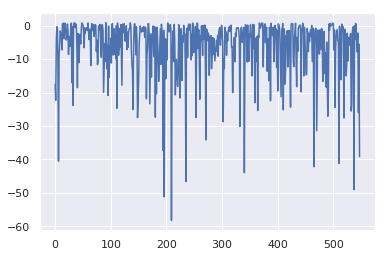

In [34]:
plt.plot(r2_score(data_model.predict('train'),data_model.getYAtStep(y_train_00),multioutput="raw_values"))
r2s =r2_score(data_model.predict('train'),data_model.getYAtStep(y_train_00),multioutput="raw_values").round(3)
r2s.argmin()

In [35]:
r2_score(data_model.predict('train'),data_model.getYAtStep(y_train_00),multioutput="variance_weighted")

-0.39234846060306017

In [36]:
r2_score(data_model.predict('test'),data_model.getYAtStep(y_test_00),multioutput="variance_weighted")

-0.7584221053234447

In [37]:
from sklearn.metrics import r2_score
print(r2_score(data_model.getRawYData(data_model.predict('test')),data_model.getRawYData(data_model.getYAtStep(y_test_00))))
r2_score(data_model.predict('train'),data_model.getYAtStep(y_train_00))

-10.569647729293088


-6.2422910100282145

In [38]:
models= reload(models)
model_plotting = models.ModelPlots(data_model, data_cleaner)
# model_plotting = models.ModelPlots(data_model,data_cleaner,split="test",y=data_model.getRawYData(y_test_00))


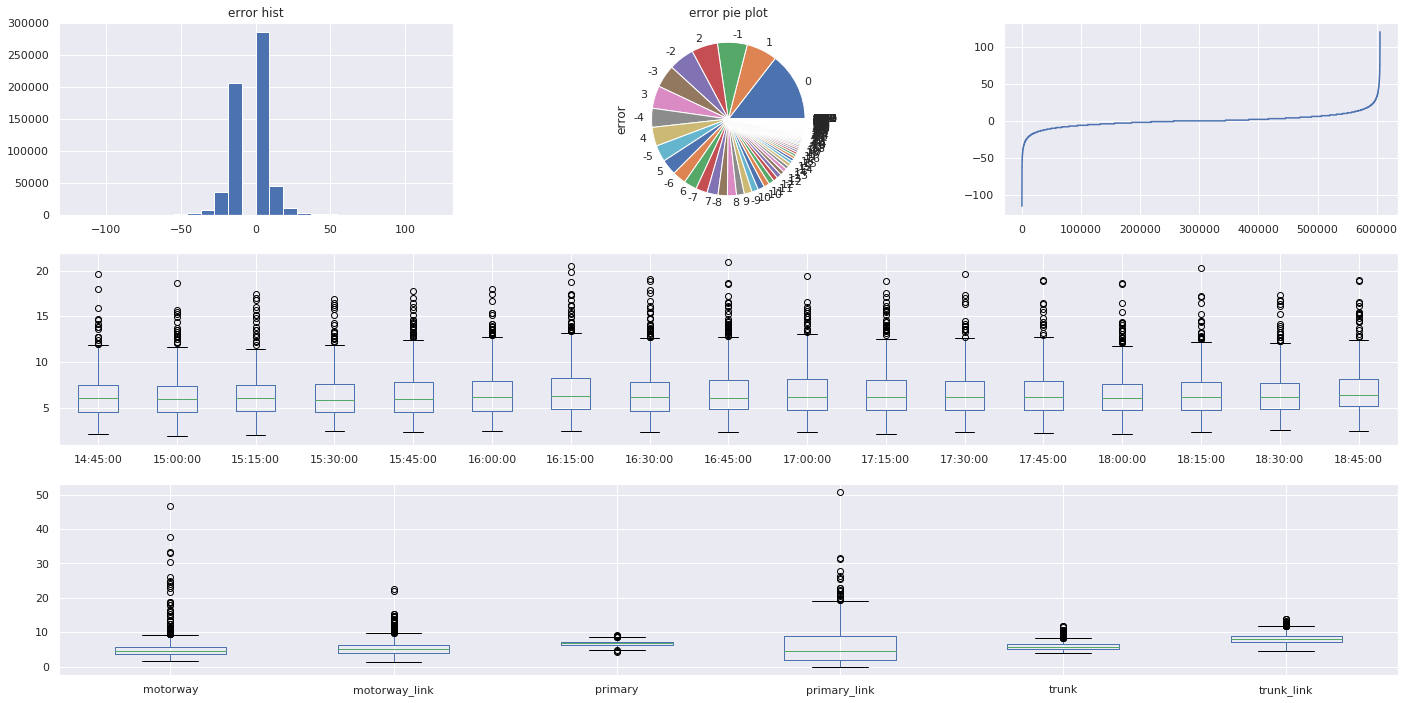

In [39]:
yDF=data_model.restorePredictionsAsDF(data_model.getYAtStep(data_model.y))
predDF = data_model.restorePredictionsAsDF( data_model.predict('full'))

time_error_df  = abs(predDF-yDF).groupby(pd.DatetimeIndex(abs(predDF-yDF).columns).time,axis=1).mean()

tag_error_df  = abs(predDF-yDF).assign(tag = data_cleaner.segments_tags).groupby('tag').mean()

fig=plt.figure(figsize=(24,12))
gs = matplotlib.gridspec.GridSpec(3, 3, figure=fig)
fig.add_subplot(gs[0, 0])
int_err = (data_model.getRawYData(data_model.predict('full')).flatten() - data_model.getRawYData(data_model.getYAtStep(data_model.y)).flatten()).astype(int)
err_series = pd.Series(int_err).value_counts()
plt.hist(int_err//10*10,bins=26);
plt.title("error hist");
fig.add_subplot(gs[0, 1])
err_series.plot("pie",label="error")
plt.title("error pie plot");
int_err.sort()
fig.add_subplot(gs[0, 2])
plt.plot(int_err)
fig.add_subplot(gs[1,:])
time_error_df.boxplot(figsize=(18,6));
fig.add_subplot(gs[2,:])
tag_error_df.T.boxplot(figsize=(18,6));
# saveFig()

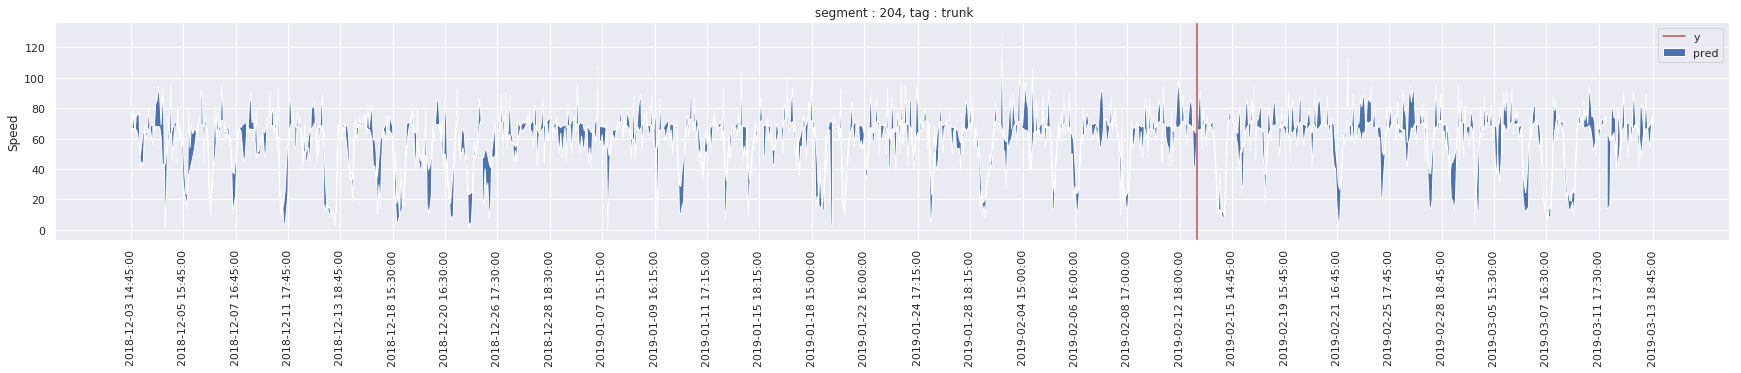

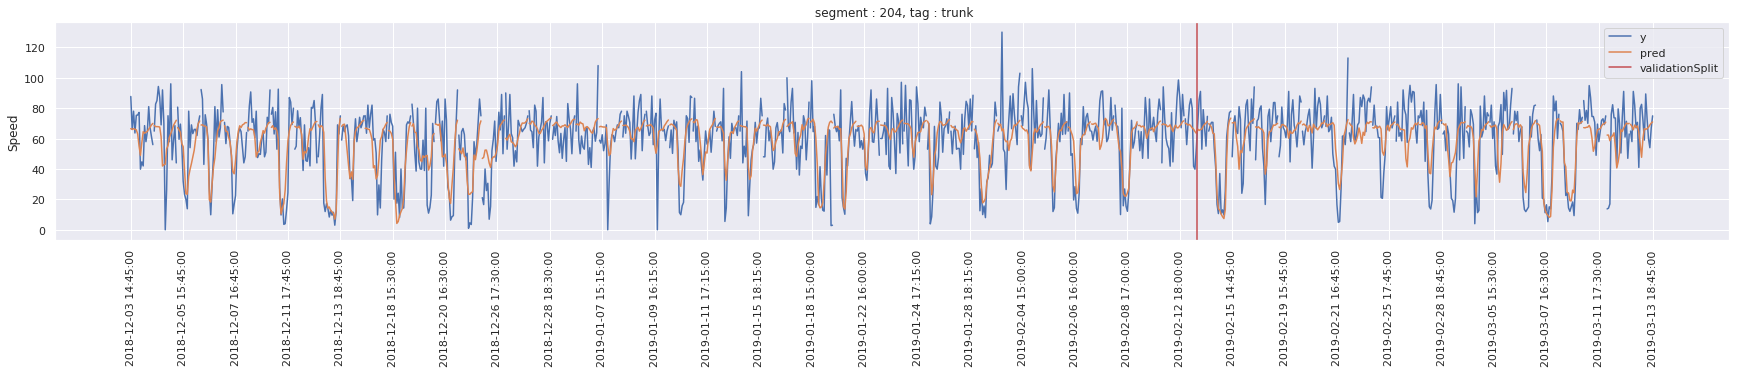

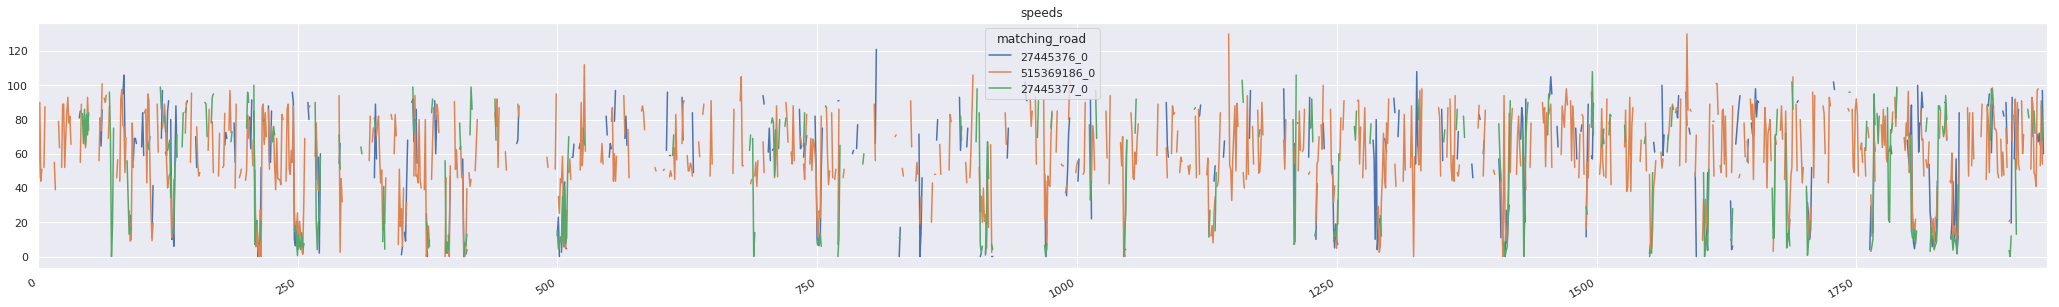

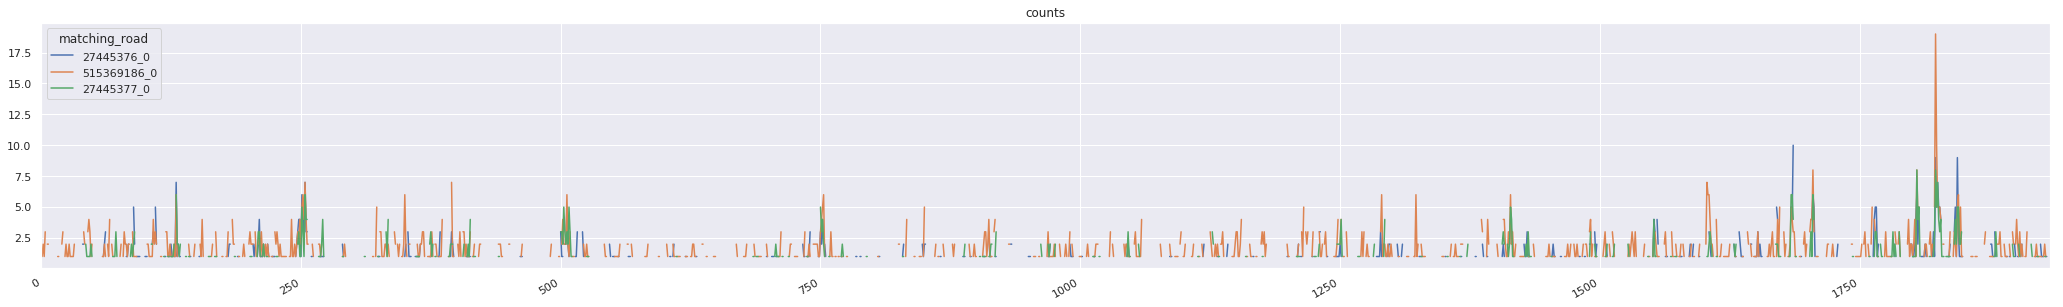

In [40]:
model_plotting.plotSegmentSeries(204,plot_surface=True)
model_plotting.plotSegmentSeries(204)
data_cleaner.plotSegmentComponents(204)

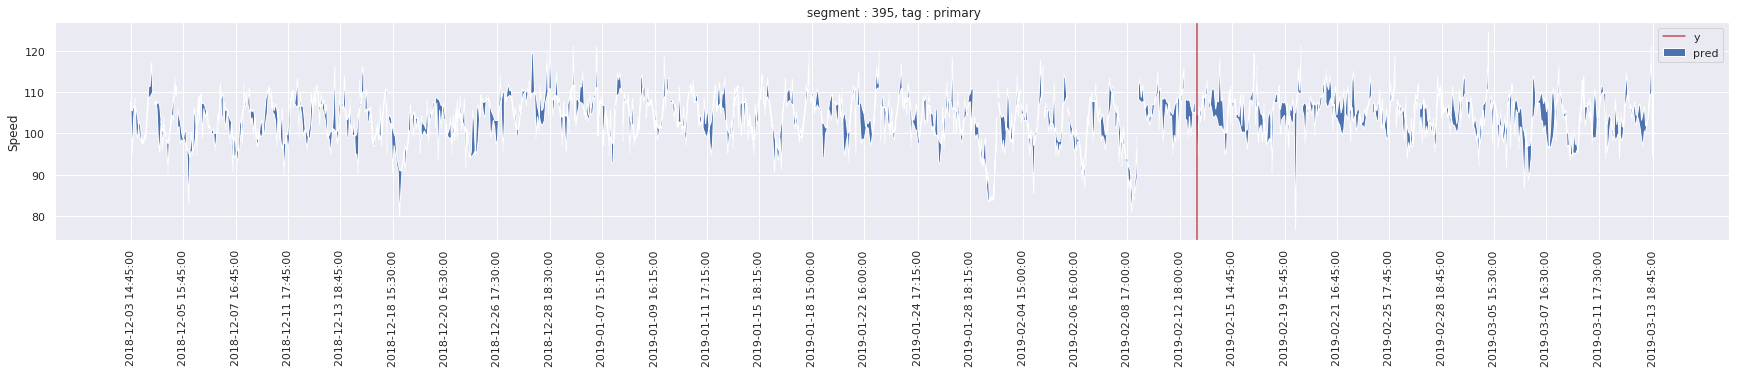

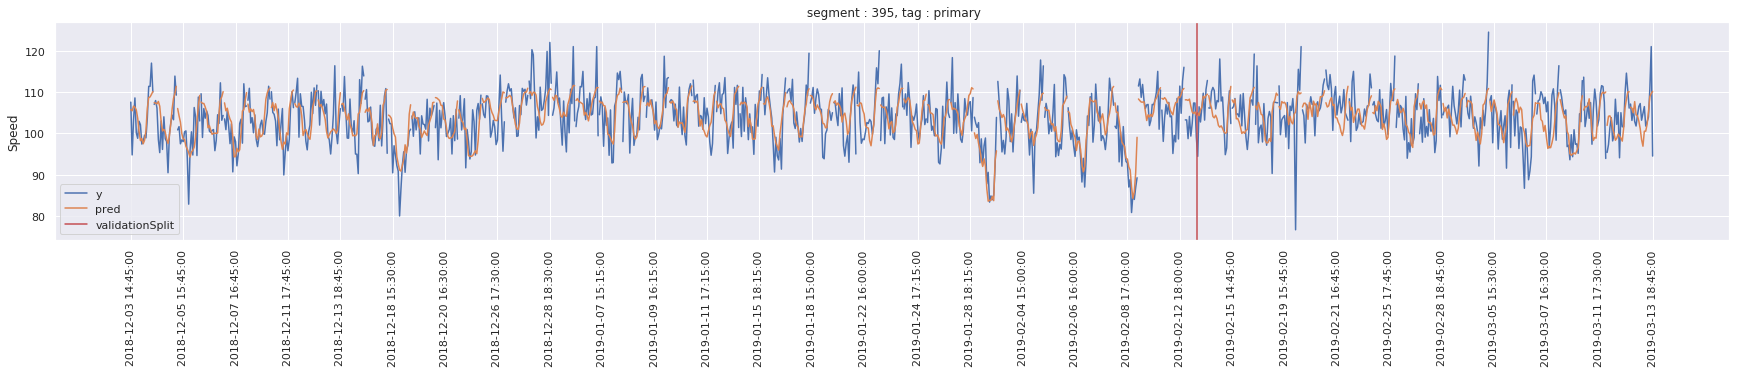

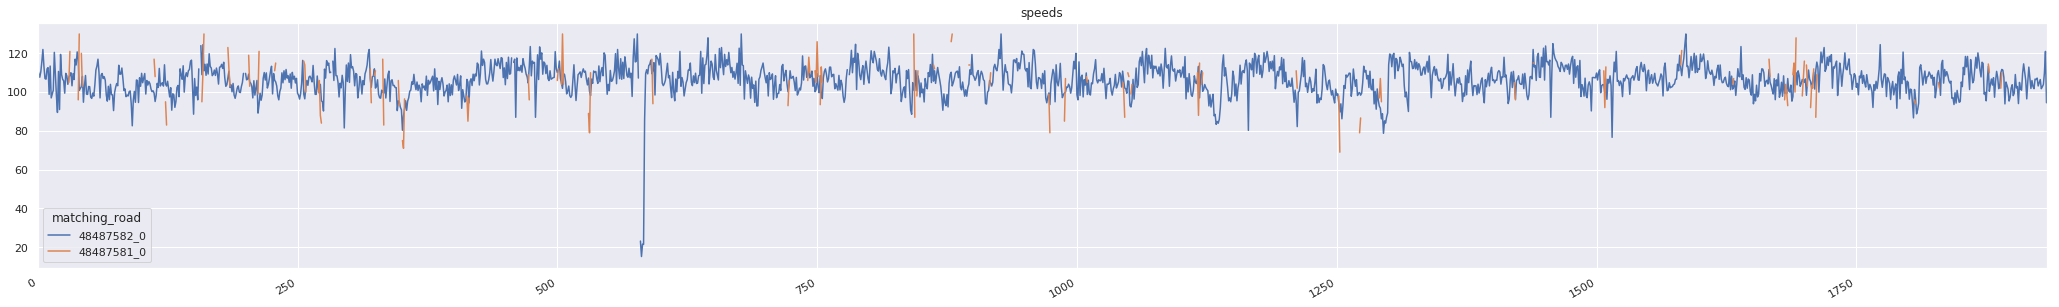

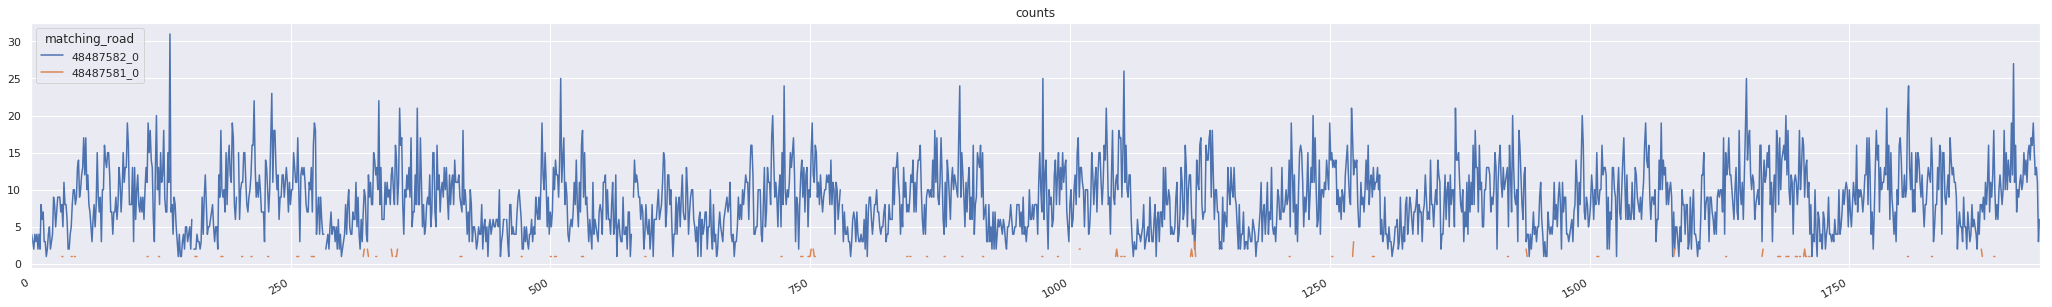

In [41]:
model_plotting.plotSegmentSeries(395,plot_surface=True)
model_plotting.plotSegmentSeries(395)
data_cleaner.plotSegmentComponents(395)

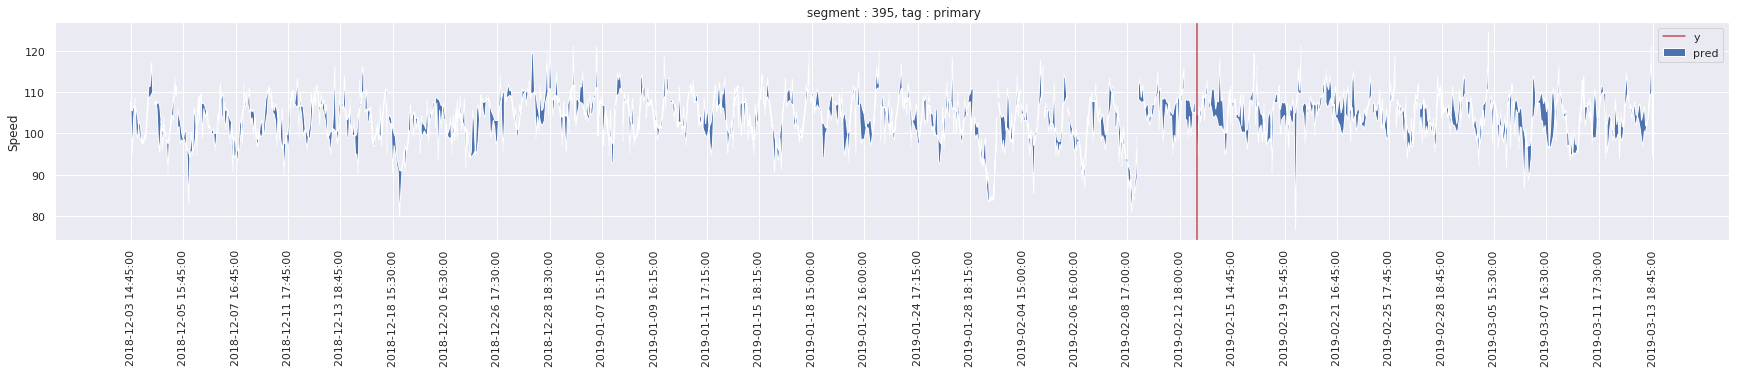

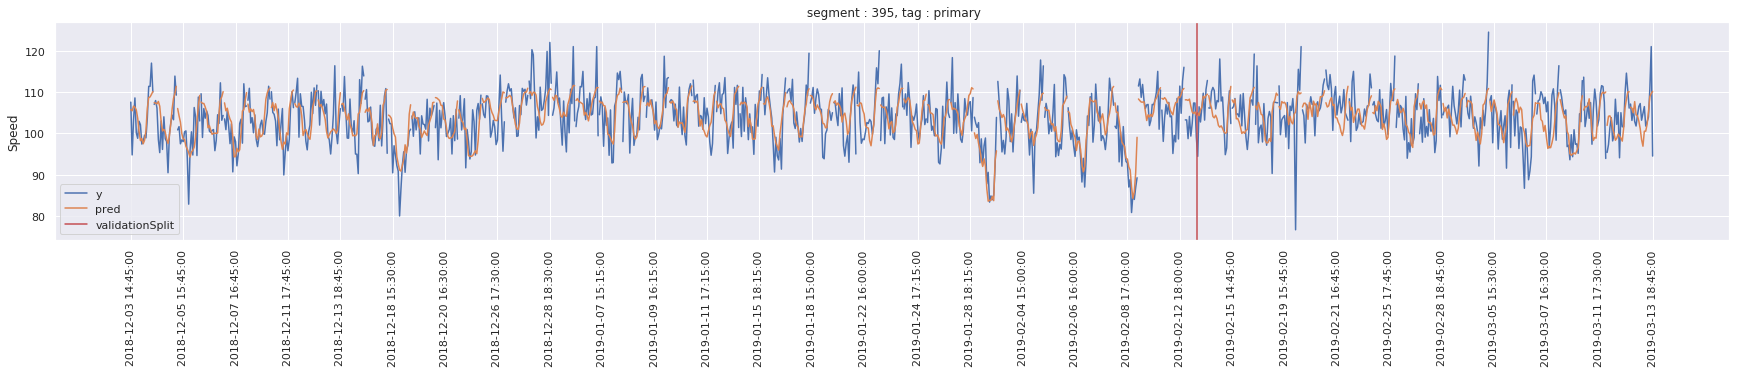

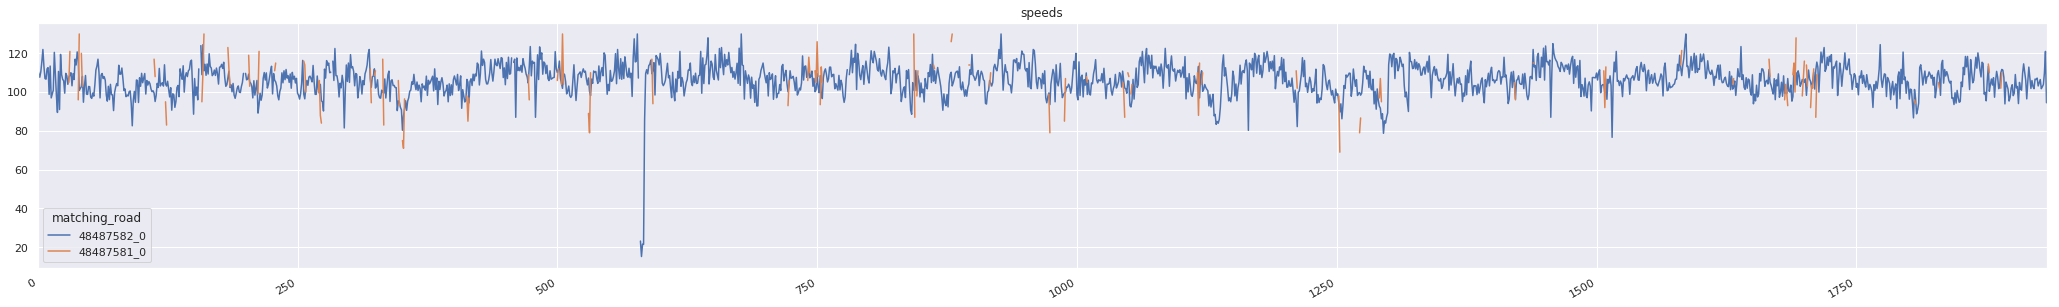

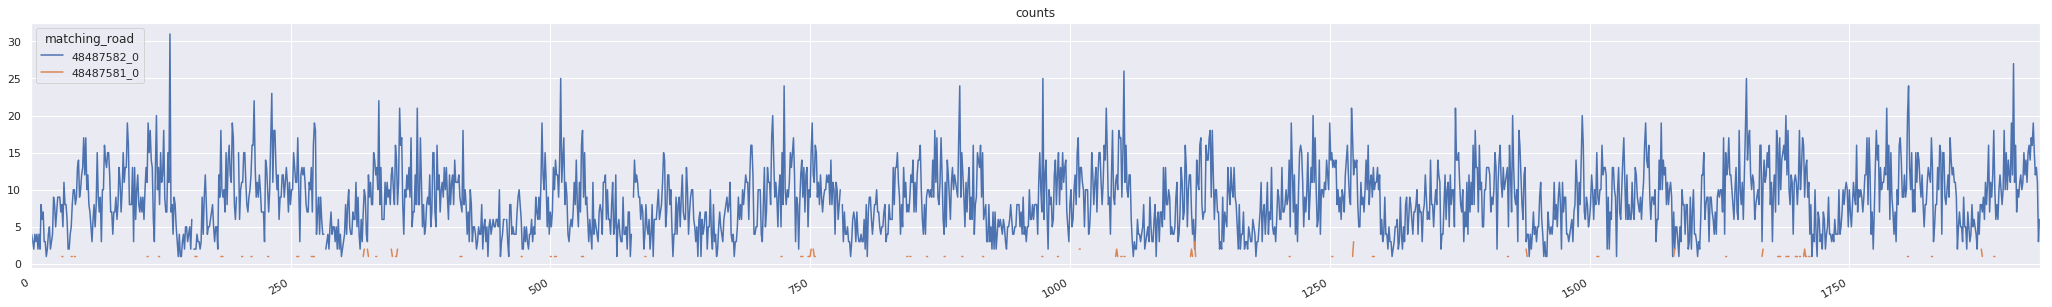

In [42]:
model_plotting.plotSegmentSeries(395,plot_surface=True)
model_plotting.plotSegmentSeries(395)
data_cleaner.plotSegmentComponents(395)

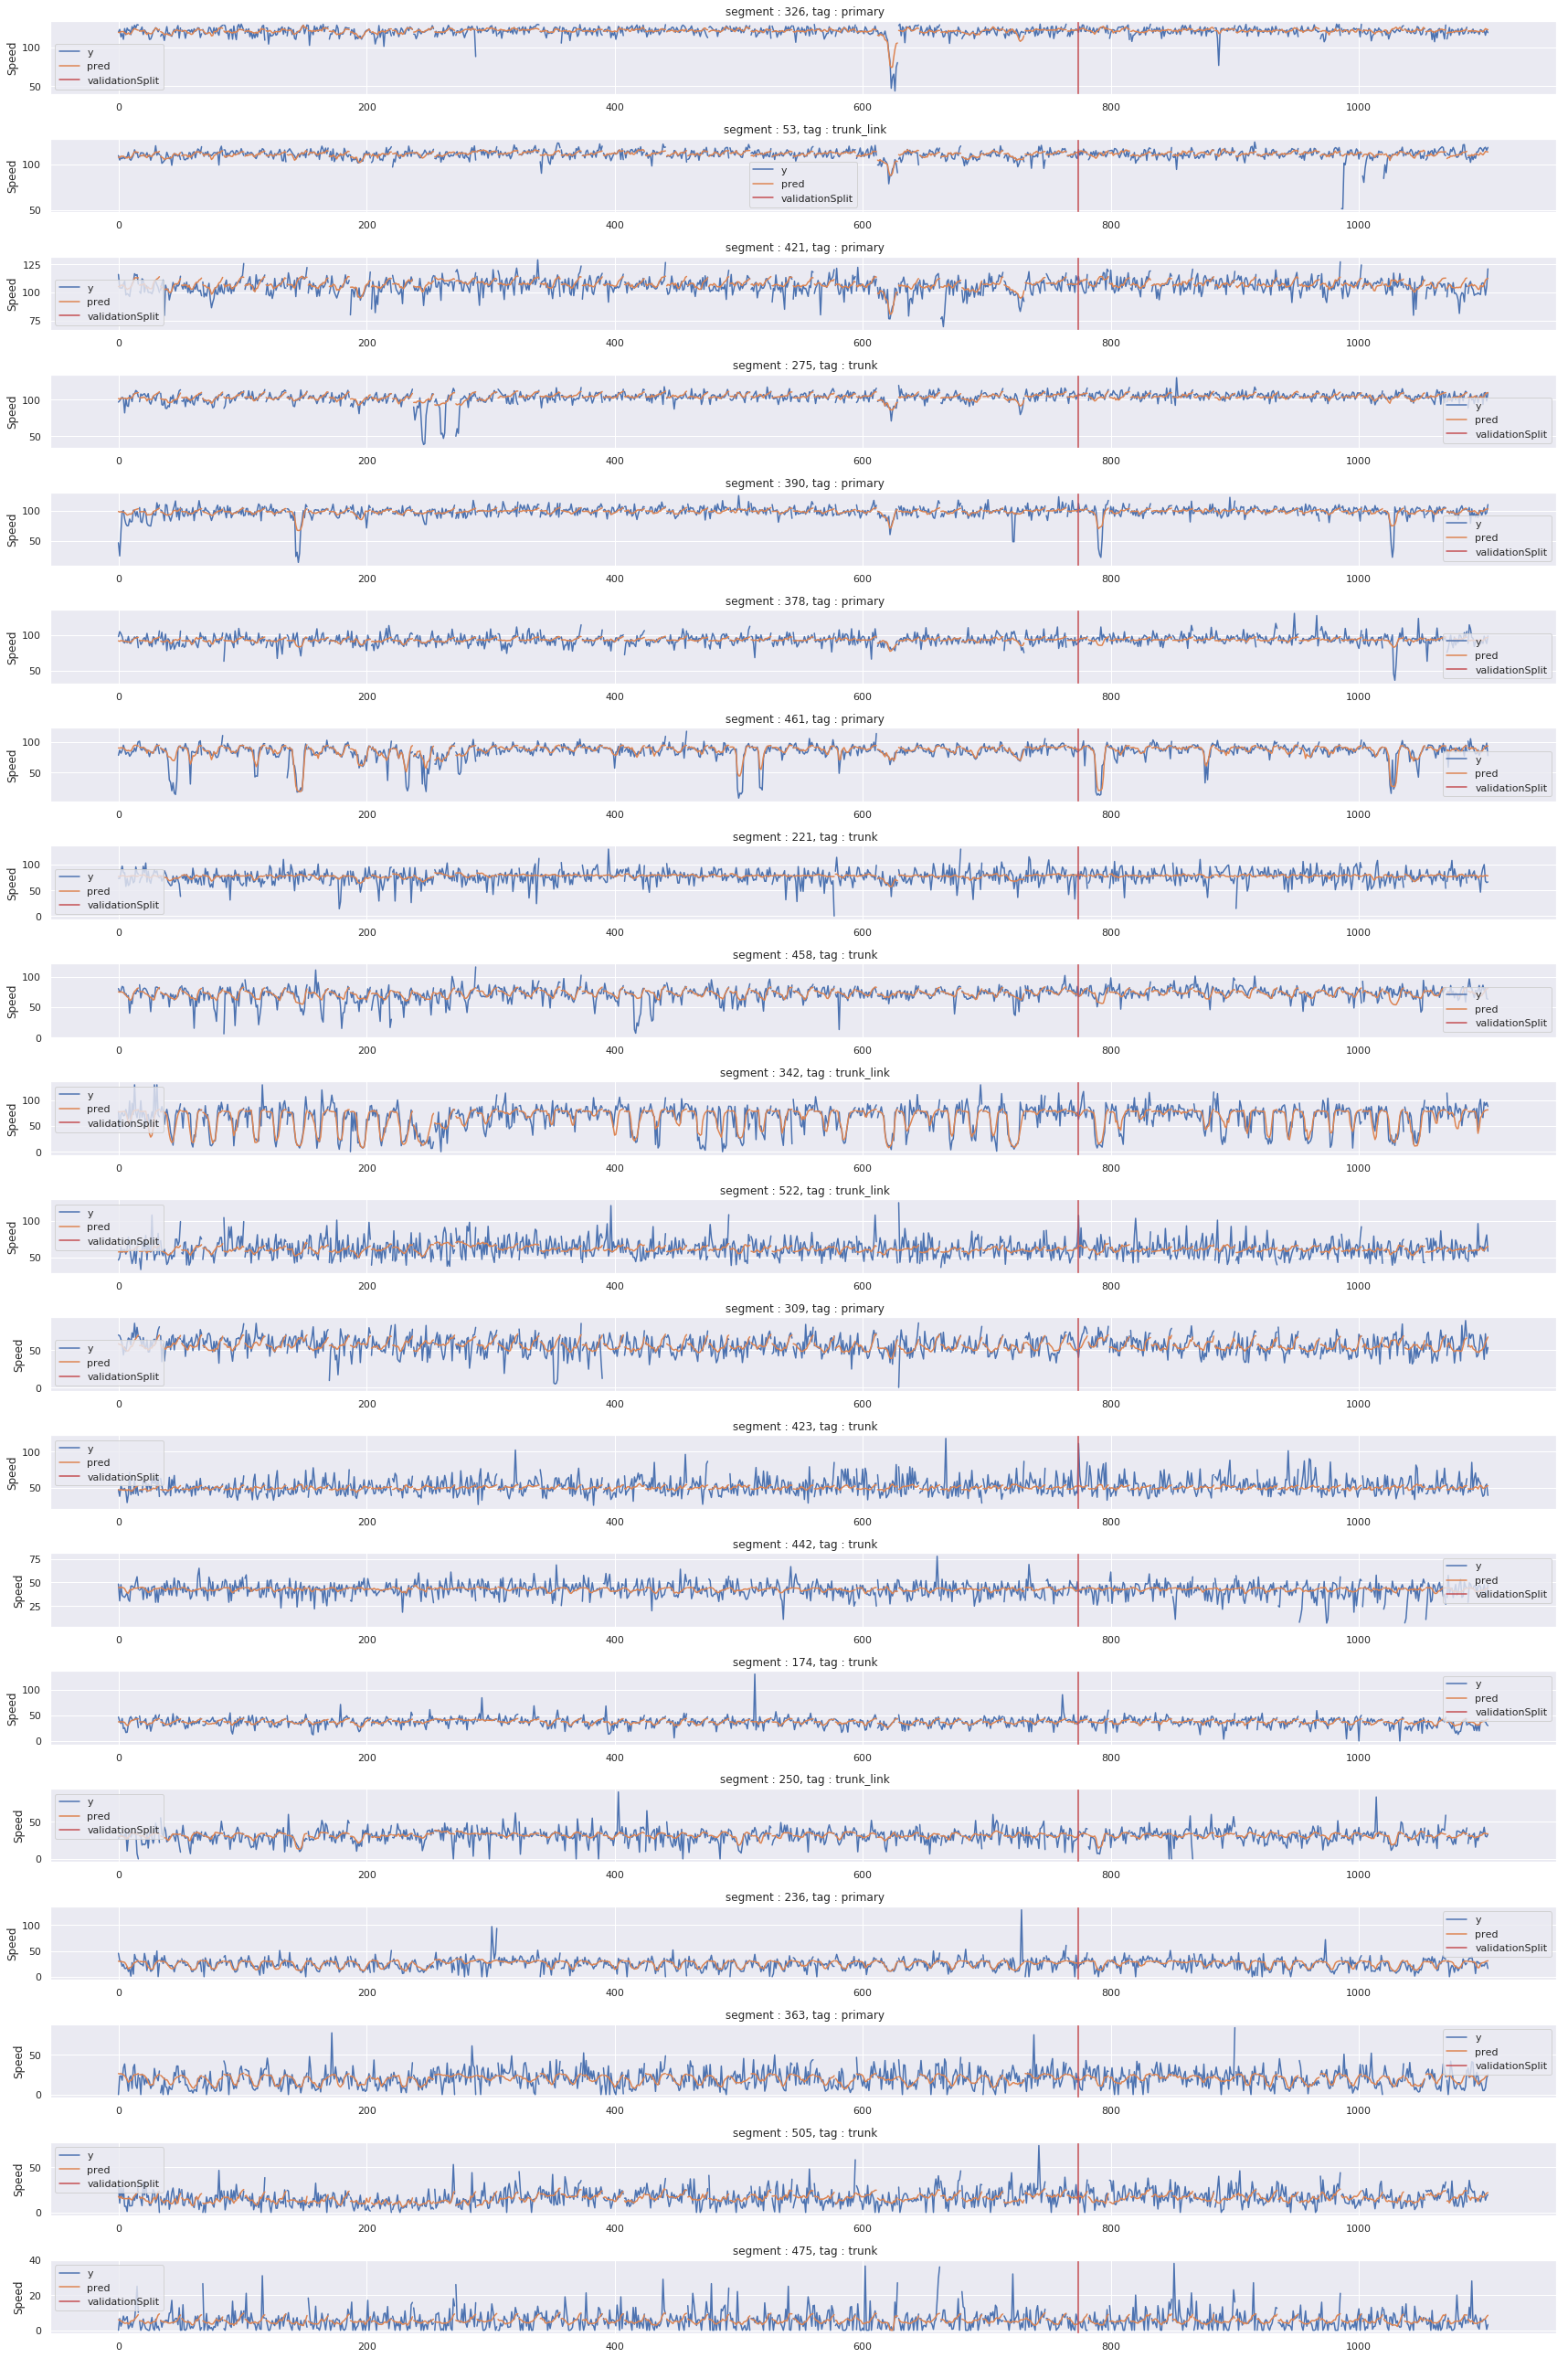

In [43]:
model_plotting.plotMultipleSegmentsSeries()

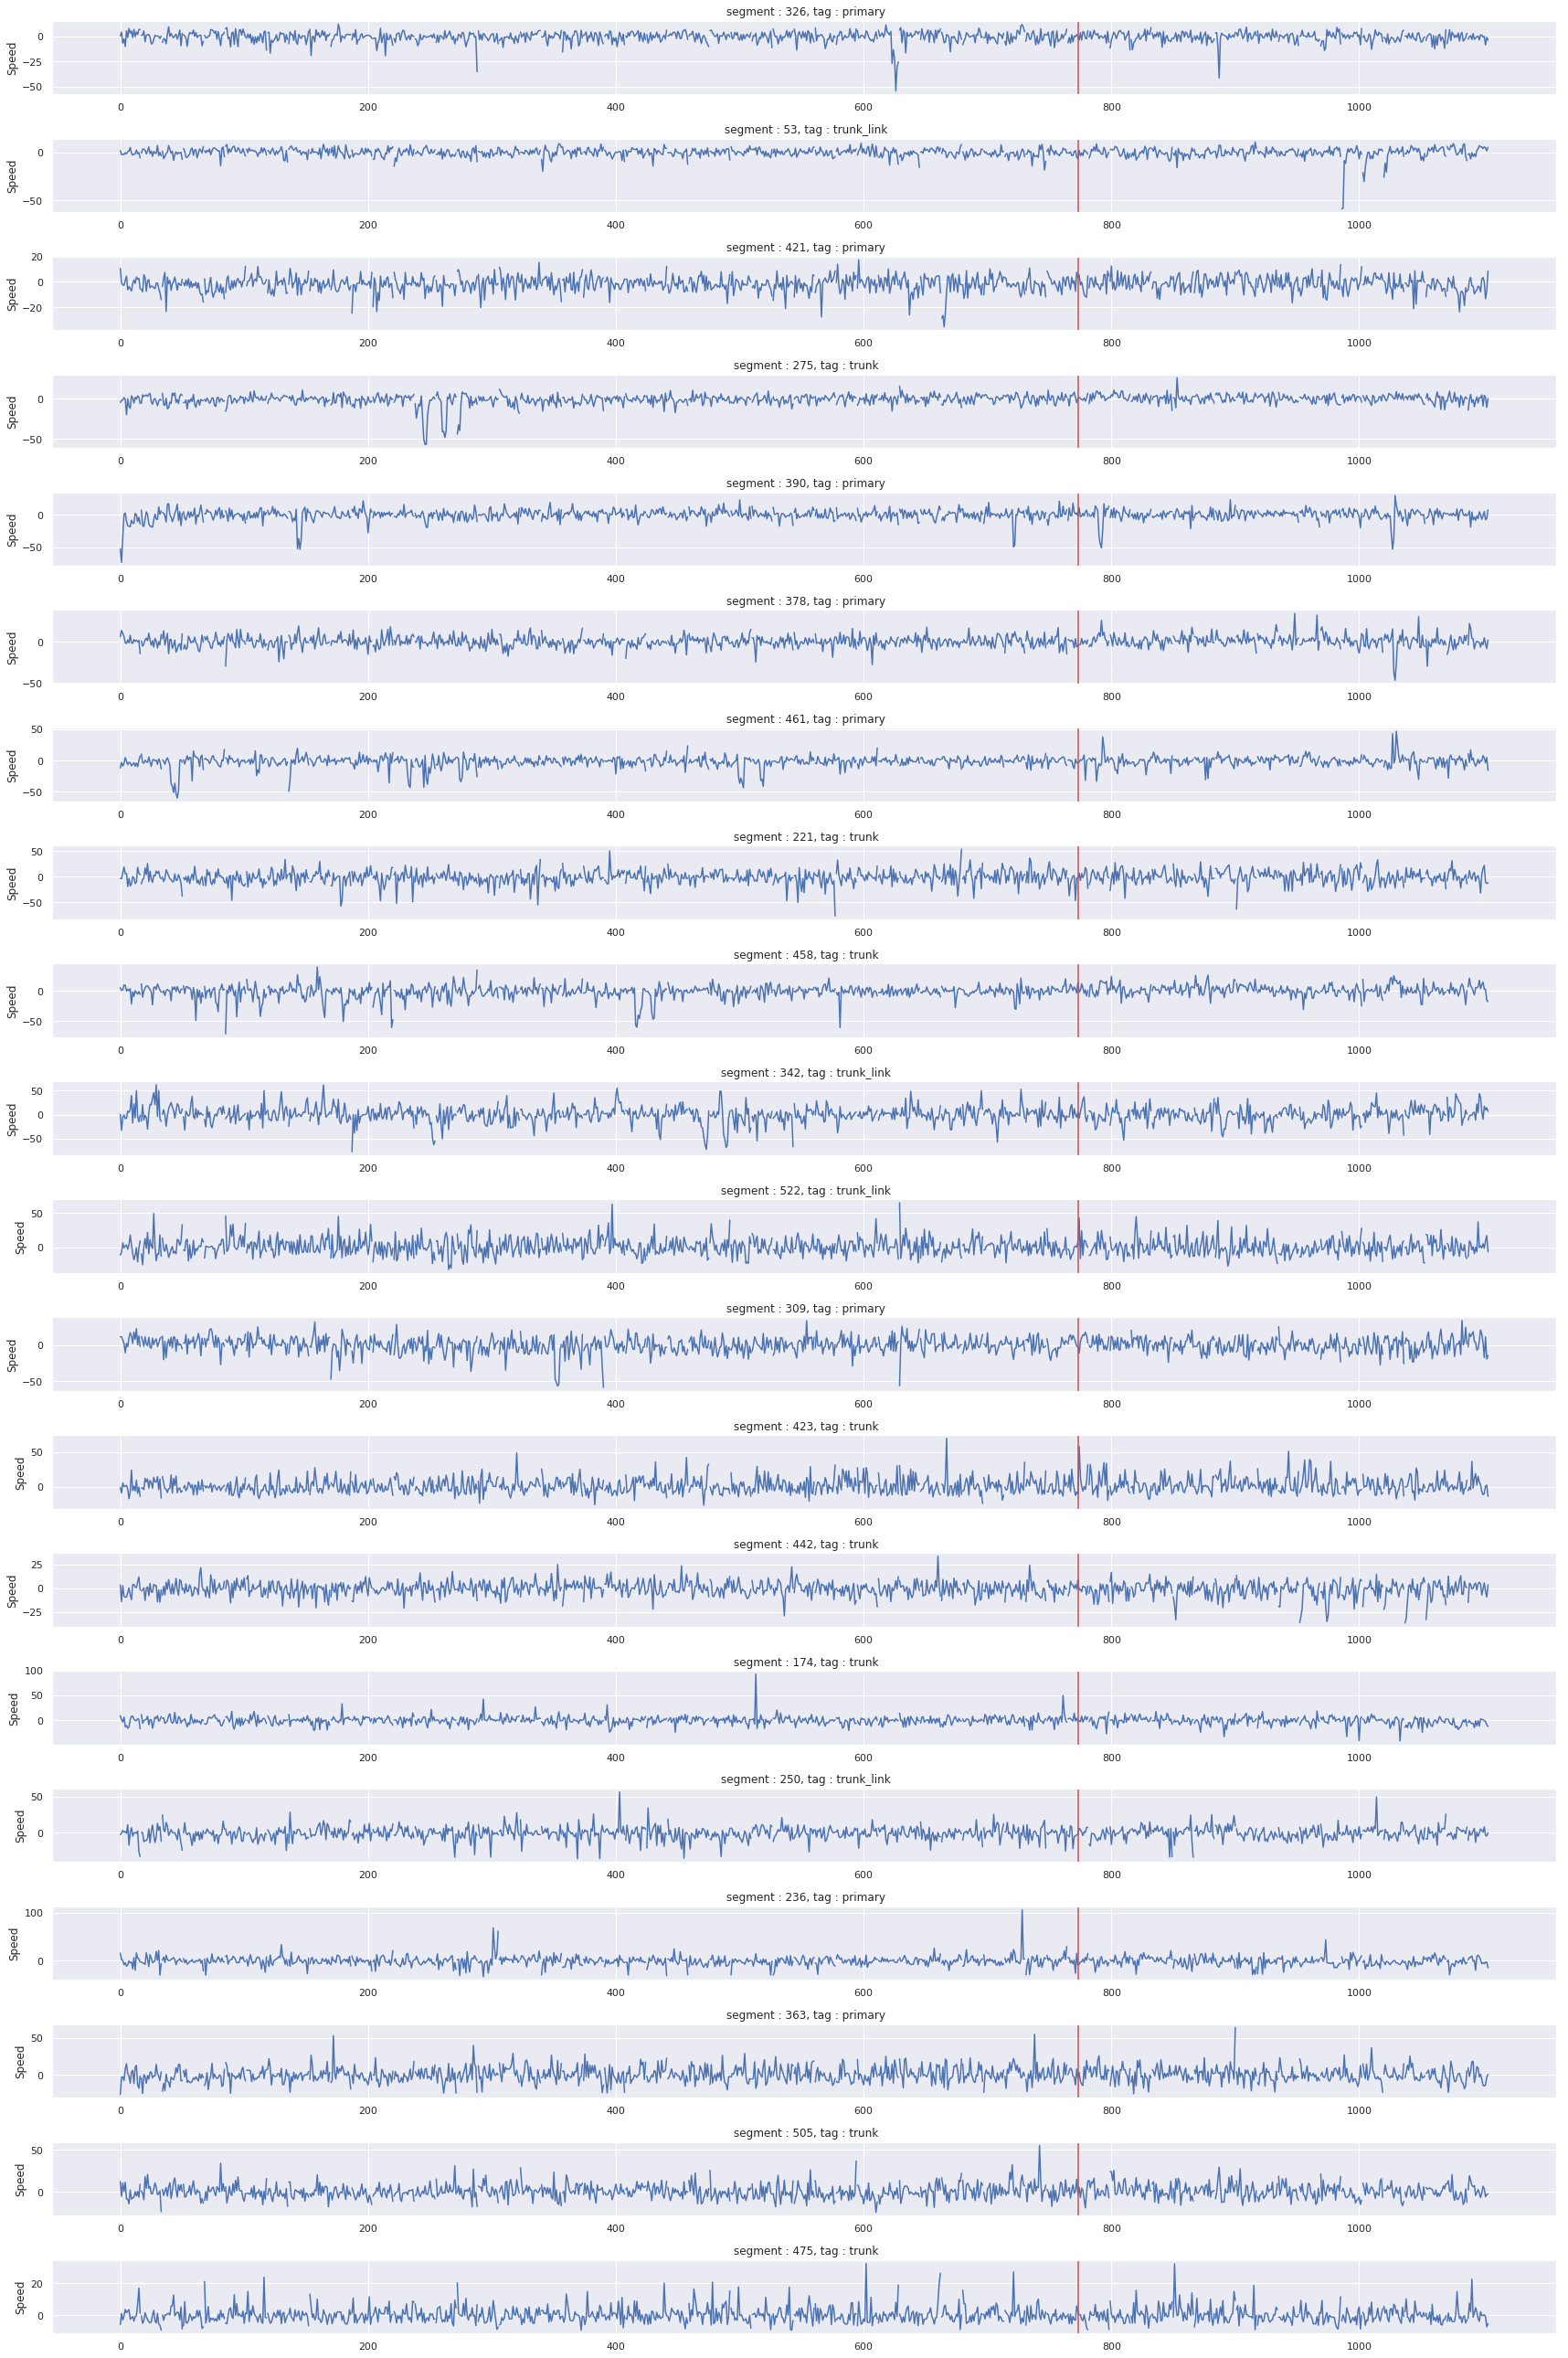

In [44]:
model_plotting.plotMultipleSegmentsSeries(plot_error=True)

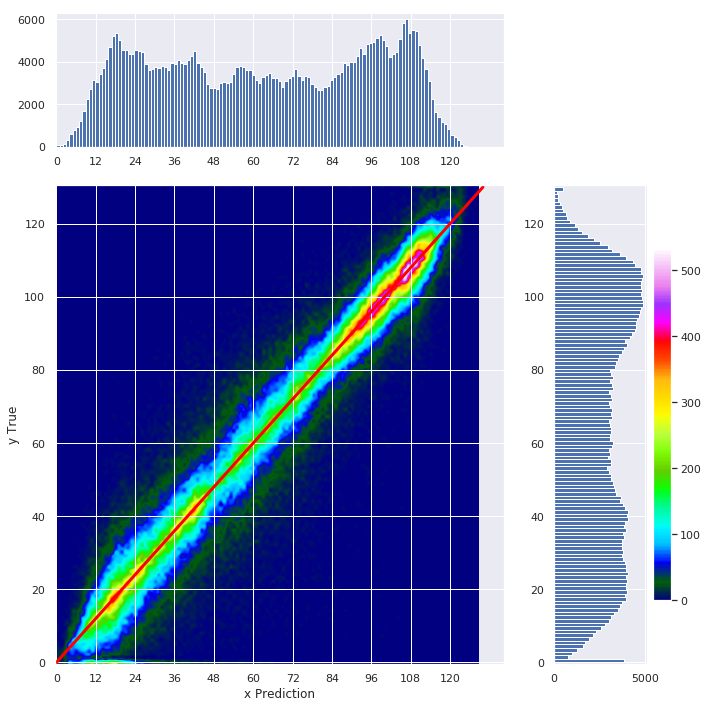

In [45]:
model_plotting.plotPredictionMatchHeatMap("train")
# saveFig()

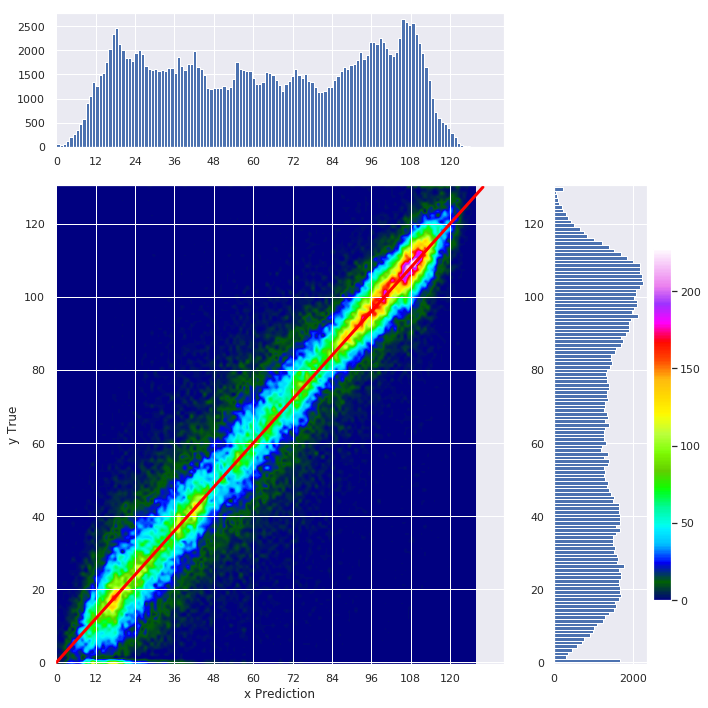

In [46]:
model_plotting.plotPredictionMatchHeatMap("valid")


In [47]:
yDF=data_model.restorePredictionsAsDF(data_model.y)
predDF = data_model.restorePredictionsAsDF( data_model.predict('full'))

# folium_map = plotPredictions(segmentsMeta,data_model, yDF, predDF, yDF.columns[np.r_[:len(yDF.columns)-1:10j].astype(int)],mergedIndex,updatedcounts)
folium_map=folium.plugins.DualMap(location=[48.10301,-1.65537],
                    zoom_start=13,
                    tiles="OpenStreetMap")

folium.features.LinearColormap([plt.cm.brg_r(0),plt.cm.brg_r(0.5)],caption="Error rate").add_to(folium_map.m1)

folium_train_map = model_plotting.plotPredictions(yDF,predDF,yDF.columns[np.r_[8:14:1].astype(int)],folium_map=folium_map.m1)
folium_validation_map = model_plotting.plotPredictions(yDF,predDF,yDF.columns[np.r_[len(yDF.columns)*valid_split+8:len(yDF.columns)*valid_split+14:1].astype(int)],folium_map=folium_map.m2)

folium_map.save(results_path+model_name+input()+' map.html')

 primary map


In [509]:
yDF=data_model.restorePredictionsAsDF(data_model.y)
predDF = data_model.restorePredictionsAsDF( data_model.predict('full'))

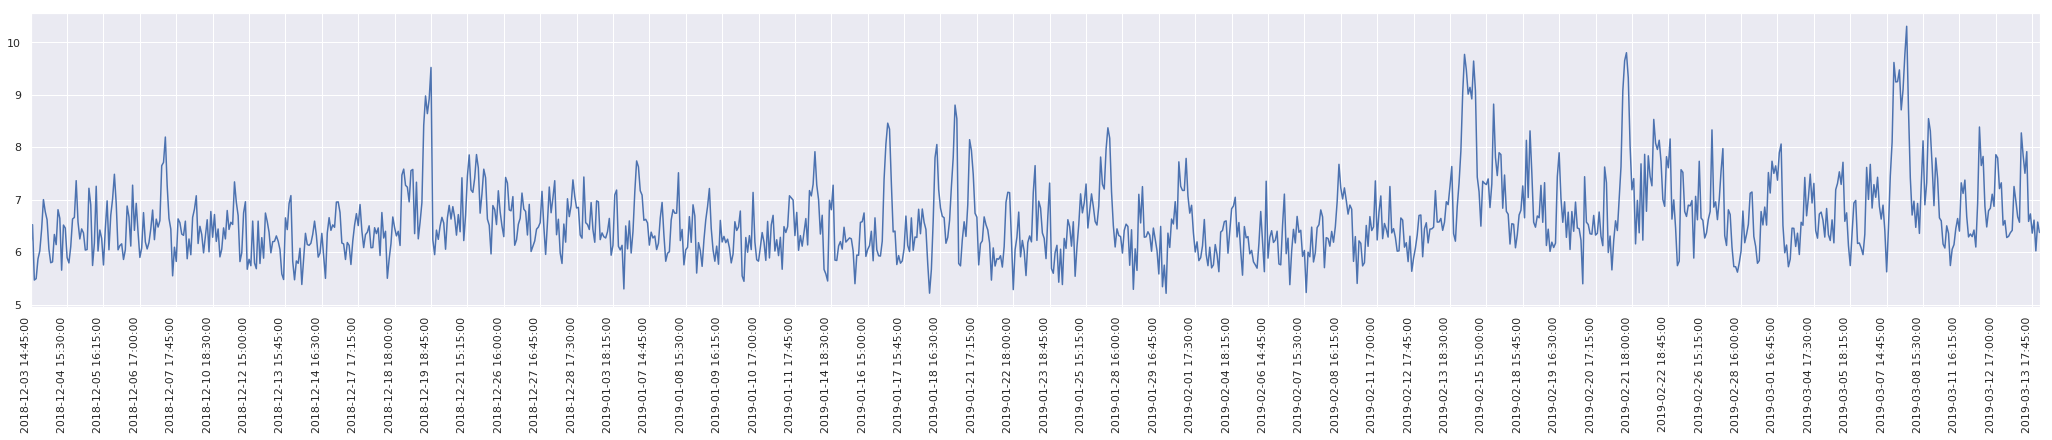

In [510]:
_20_error=abs(predDF-yDF)
_20_error.mean().plot(use_index=False,figsize=(36,6))
plt.xticks(*list(zip(*list(enumerate(predDF.columns))[::20])),rotation=90);

In [511]:
_20_error=abs(predDF-yDF)>20

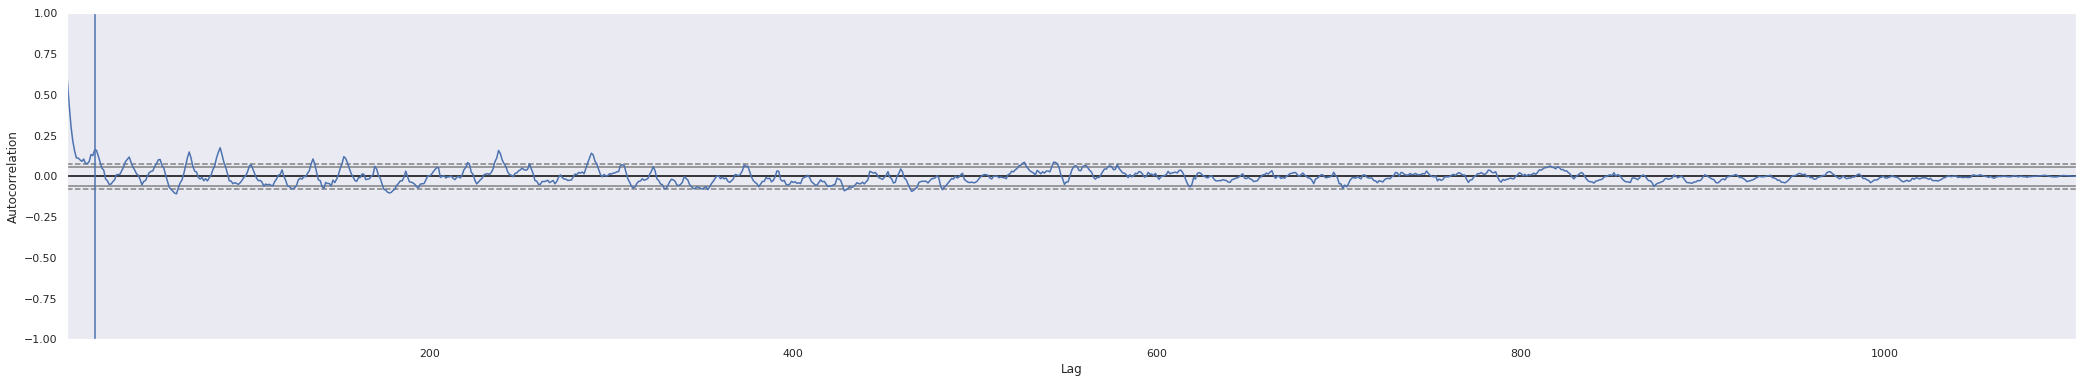

In [512]:
plt.figure(figsize=(36,6))
pd.plotting.autocorrelation_plot(_20_error.mean())
plt.axvline(16)

In [513]:
speedDF.shape

(556, 1300)

In [514]:
_20_error.sum(axis=1).values[np.where(_20_error.sum(axis=1).values>80)[0]]

array([ 88, 186, 103, 104, 159, 125,  99, 290,  88, 114, 111,  87, 161,
       108, 136,  98, 271, 151, 194, 165, 170, 179, 100, 173, 298, 152,
       133, 131,  85, 109, 162, 105, 306,  89, 141, 221, 102, 105, 193,
        97, 119, 103, 171,  82, 108, 102, 203,  81, 130, 164, 233,  92,
        92, 117,  85,  86, 303, 179, 375, 191,  90, 265, 110,  98, 194,
       272, 176, 244, 172, 129, 171, 138,  88, 146, 138,  98, 124, 204,
       115, 208,  95,  96, 127, 101, 112, 154, 162, 100, 152, 188,  86,
       137,  86,  83,  95, 177, 114, 106, 140, 123, 161, 142, 158,  91,
       132, 131, 120, 121, 329, 121, 154, 106, 267, 126, 173,  85, 105,
        97, 112, 159, 147, 145,  86, 122,  99,  98, 106, 237, 102, 173,
       128])

In [515]:
np.where(_20_error.sum(axis=1).values>80)[0]

array([  1,   3,  13,  14,  15,  18,  19,  32,  35,  36,  38,  49,  50,
        53,  67,  75,  76,  77,  85,  86,  87,  98, 103, 104, 115, 116,
       121, 123, 127, 133, 134, 137, 138, 141, 145, 158, 165, 169, 170,
       175, 177, 178, 183, 184, 187, 189, 191, 201, 204, 205, 206, 210,
       222, 223, 225, 249, 250, 251, 255, 258, 259, 281, 283, 293, 296,
       300, 303, 304, 305, 309, 310, 316, 317, 321, 322, 325, 335, 345,
       348, 358, 370, 371, 372, 376, 377, 380, 396, 403, 405, 406, 413,
       415, 423, 424, 427, 429, 430, 431, 432, 437, 443, 454, 459, 461,
       463, 466, 477, 491, 495, 496, 497, 498, 501, 504, 506, 507, 508,
       509, 515, 521, 523, 525, 527, 528, 529, 530, 536, 545, 548, 553,
       554])

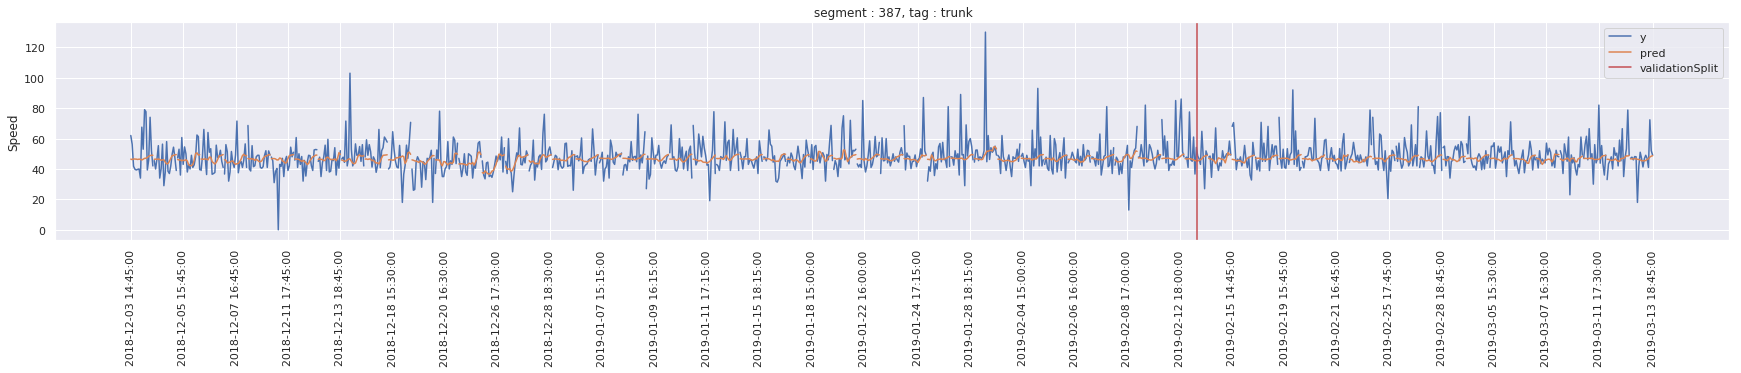

In [516]:
model_plotting.plotSegmentSeries(387)

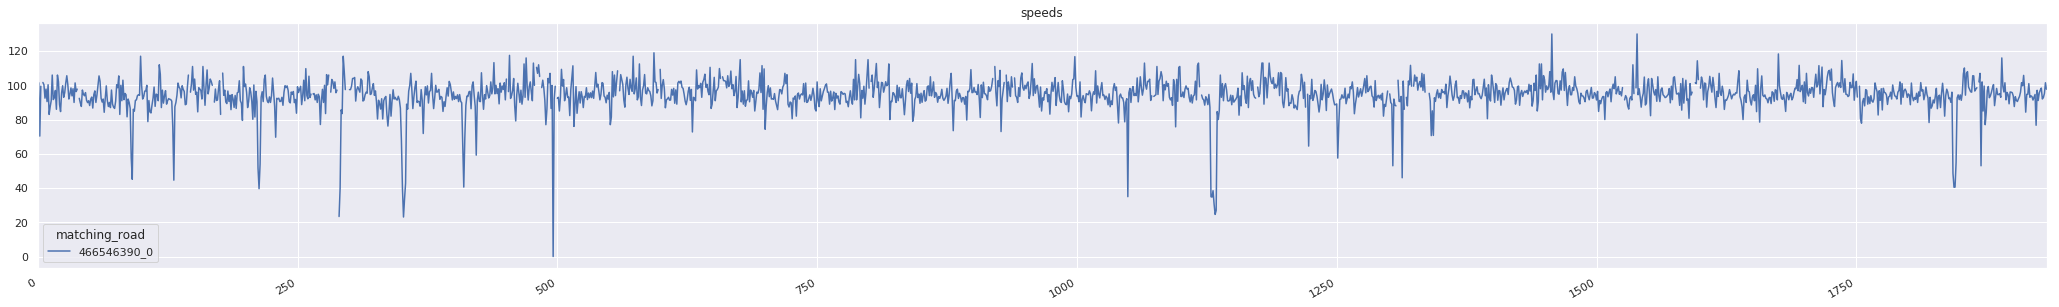

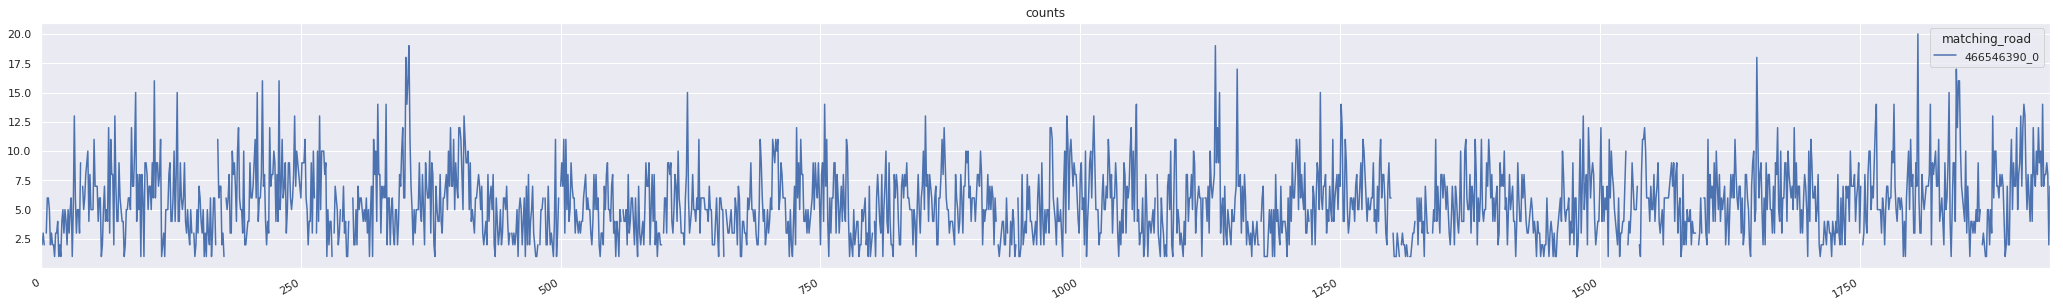

In [253]:
data_cleaner.plotSegmentComponents(387)

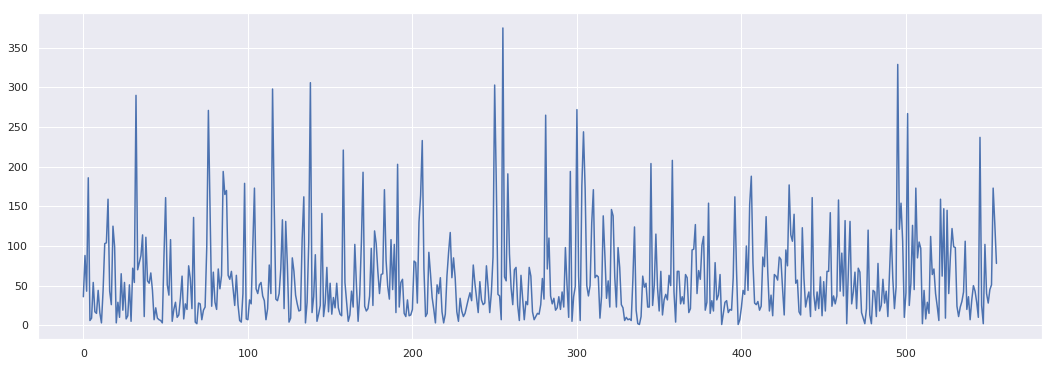

In [517]:
plt.figure(figsize=(18,6))
plt.plot(_20_error.sum(axis=1).values)

In [518]:
error = data_model.getRawYData(data_model.predict("test").clip(0)) - data_model.getRawYData(y_test_00)

In [519]:
round_error= abs(error.flatten().round())//5*5

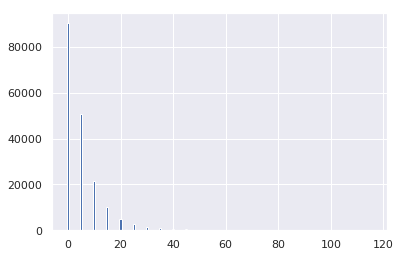

In [520]:
plt.bar(*np.unique(round_error,return_counts=True),);

In [521]:
pd.DataFrame(np.unique(round_error,return_counts=True),index=["error range","number of occurrences" ])

0        1        2        3       4       5   \
error range                0.0      5.0     10.0     15.0    20.0    25.0   
number of occurrences  90323.0  50894.0  21472.0  10190.0  4937.0  2613.0   

                           6      7      8      9   ...    14    15    16  \
error range              30.0   35.0   40.0   45.0  ...  70.0  75.0  80.0   
number of occurrences  1515.0  979.0  576.0  370.0  ...  56.0  40.0  18.0   

                         17    18    19     20     21     22     23  
error range            85.0  90.0  95.0  100.0  105.0  110.0  115.0  
number of occurrences  13.0  15.0   9.0    4.0    5.0    3.0    1.0  

[2 rows x 24 columns]

Text(0.5, 1.0, 'error distribution')

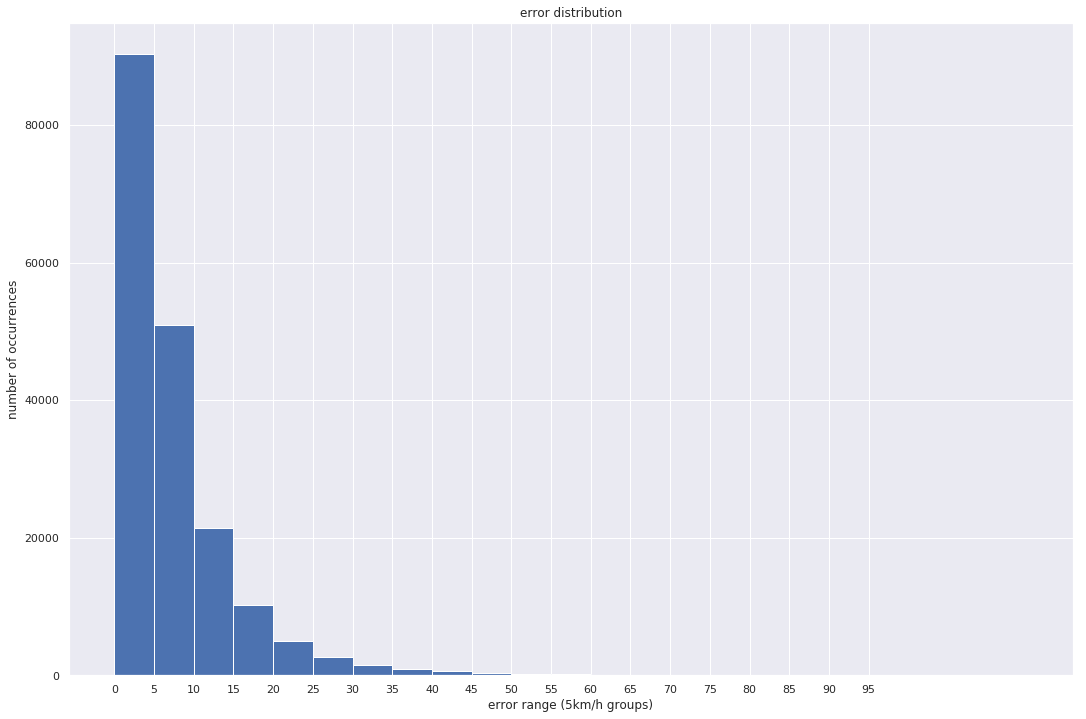

In [522]:
plt.figure(figsize=(18,12))
plt.hist(sorted(round_error),bins=23);
plt.xticks(range(0,100,5),range(0,100,5));
plt.xlabel("error range (5km/h groups)")
plt.ylabel("number of occurrences")
plt.title("error distribution")

In [523]:

params        = {}

lastValue_data_model    = models.DataModel( speedDF,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params )
lastValue_data_model.preprocessData()

model =models.BaseModels("lastValue",historic_data=speedDF[speedDF.columns[:int(0.7*len(speedDF.columns))]])
lastValue_data_model.model=model
lastValue_model_plotting = models.ModelPlots(lastValue_data_model, data_cleaner)


In [524]:

params        = {}

timehistoric_data_model    = models.DataModel( speedDF,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params )
timehistoric_data_model.preprocessData()

model =models.BaseModels("timeHistoric",historic_data=speedDF[speedDF.columns[:int(0.7*len(speedDF.columns))]])
timehistoric_data_model.model=model


In [525]:

params        = {}

historic_data_model    = models.DataModel( speedDF,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params )
historic_data_model.preprocessData()

model =models.BaseModels("historic",historic_data=speedDF[speedDF.columns[:int(0.7*len(speedDF.columns))]])
historic_data_model.model=model


In [526]:
params        = {}

AR5_data_model    = models.DataModel( speedDF,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params )
AR5_data_model.preprocessData()

model =models.BaseModels("AR5",historic_data=speedDF[speedDF.columns[:int(0.7*len(speedDF.columns))]],lag=input_lag)
AR5_data_model.model=model


Training the AR(5) model
Train data shape: (556, 909)

Filling the voids...
Filling done. New train data shape: (556, 6921)

Training the models...
Params: max_lag: 3


/home/infres/mbouchouia/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)



Training finished !


In [527]:
# mlp_model_plotting = models.ModelPlots(mlpModel, data_cleaner, split="test", y=data_model.getRawYData(y_test_00))
lastValue_model_plotting = models.ModelPlots(lastValue_data_model,data_cleaner,split="test",y=data_model.getRawYData(y_test_00))
historic_model_plotting = models.ModelPlots(historic_data_model,data_cleaner,split="test",y=data_model.getRawYData(y_test_00))
timehistoric_model_plotting = models.ModelPlots(timehistoric_data_model,data_cleaner,split="test",y=data_model.getRawYData(y_test_00))
AR5_model_plotting = models.ModelPlots(AR5_data_model,data_cleaner,split="test",y=data_model.getRawYData(y_test_00))
model_plotting = models.ModelPlots(data_model,data_cleaner,split="test",y=data_model.getRawYData(y_test_00))


In [528]:
model_plotting.y.shape

(332, 556)

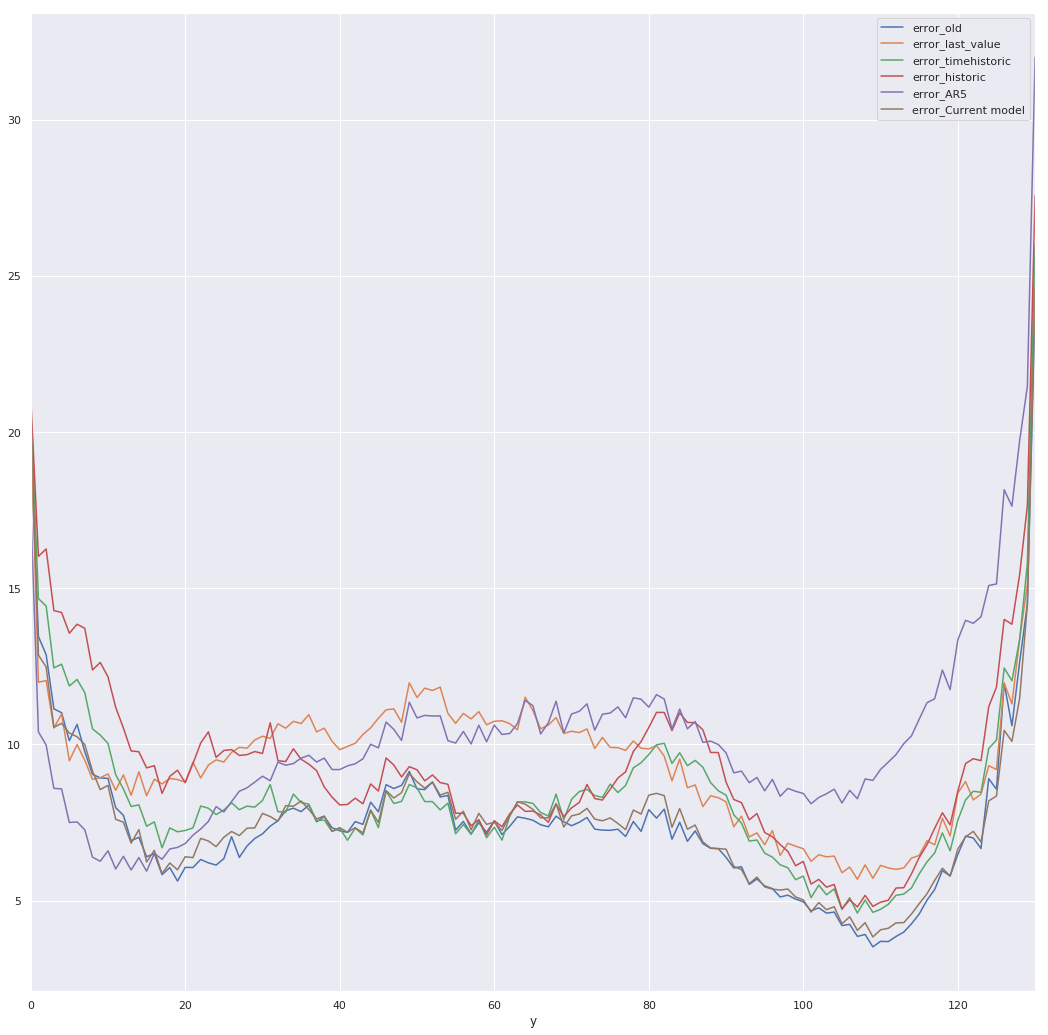

In [529]:
fig = plt.figure(figsize=(18,18))
ax=plt.gca()
oldModelPlotting.plotDiscreteSpeedError(ax,"old")
lastValue_model_plotting.plotDiscreteSpeedError(ax,"last_value")
timehistoric_model_plotting.plotDiscreteSpeedError(ax,"timehistoric")
historic_model_plotting.plotDiscreteSpeedError(ax,"historic")
AR5_model_plotting.plotDiscreteSpeedError(ax,"AR5")
model_plotting.plotDiscreteSpeedError(ax,"Current model")

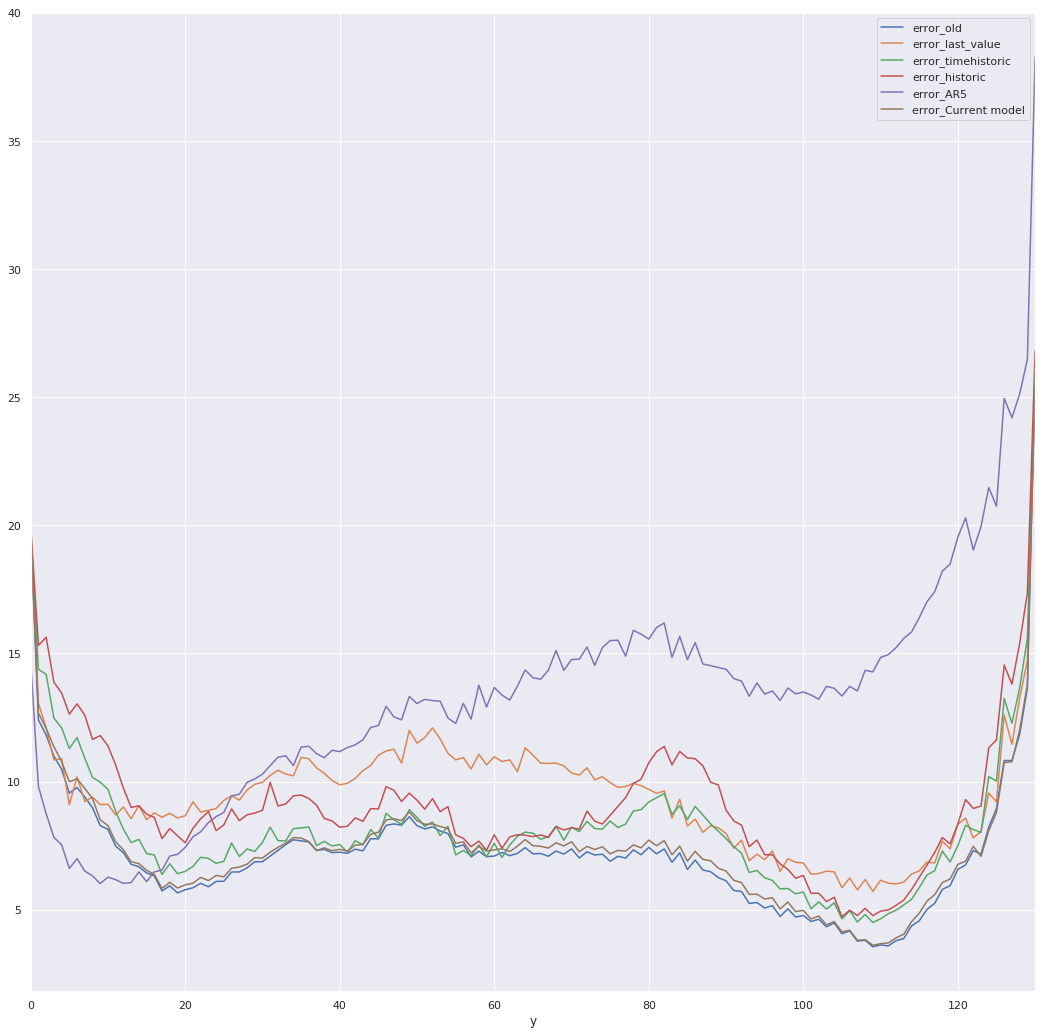

In [178]:
fig = plt.figure(figsize=(18,18))
ax=plt.gca()
oldModelPlotting.plotDiscreteSpeedError(ax,"old")
lastValue_model_plotting.plotDiscreteSpeedError(ax,"last_value")
timehistoric_model_plotting.plotDiscreteSpeedError(ax,"timehistoric")
historic_model_plotting.plotDiscreteSpeedError(ax,"historic")
AR5_model_plotting.plotDiscreteSpeedError(ax,"AR5")
model_plotting.plotDiscreteSpeedError(ax,"Current model")

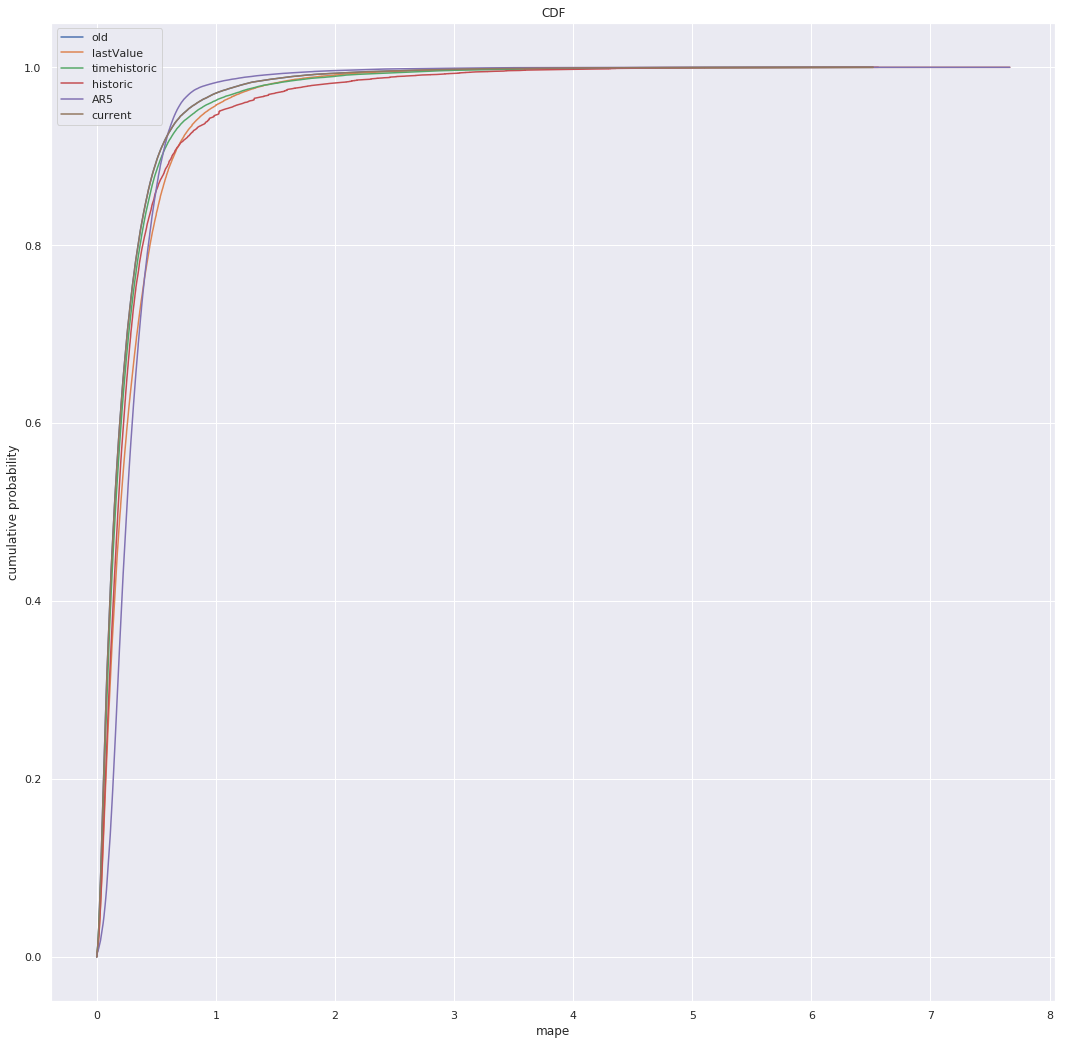

In [75]:
plt.figure(figsize=(18,18))
oldModelPlotting.cdfPlot(error_type="mape",label="old",plot_lines=False)
lastValue_model_plotting.cdfPlot(error_type="mape",label="lastValue",plot_lines=False)
timehistoric_model_plotting.cdfPlot(error_type="mape",label="timehistoric",plot_lines=False)
historic_model_plotting.cdfPlot(error_type="mape",label="historic",plot_lines=False)
AR5_model_plotting.cdfPlot(error_type="mape",label="AR5",plot_lines=False)
model_plotting.cdfPlot(error_type="mape",label="current",plot_lines=False)


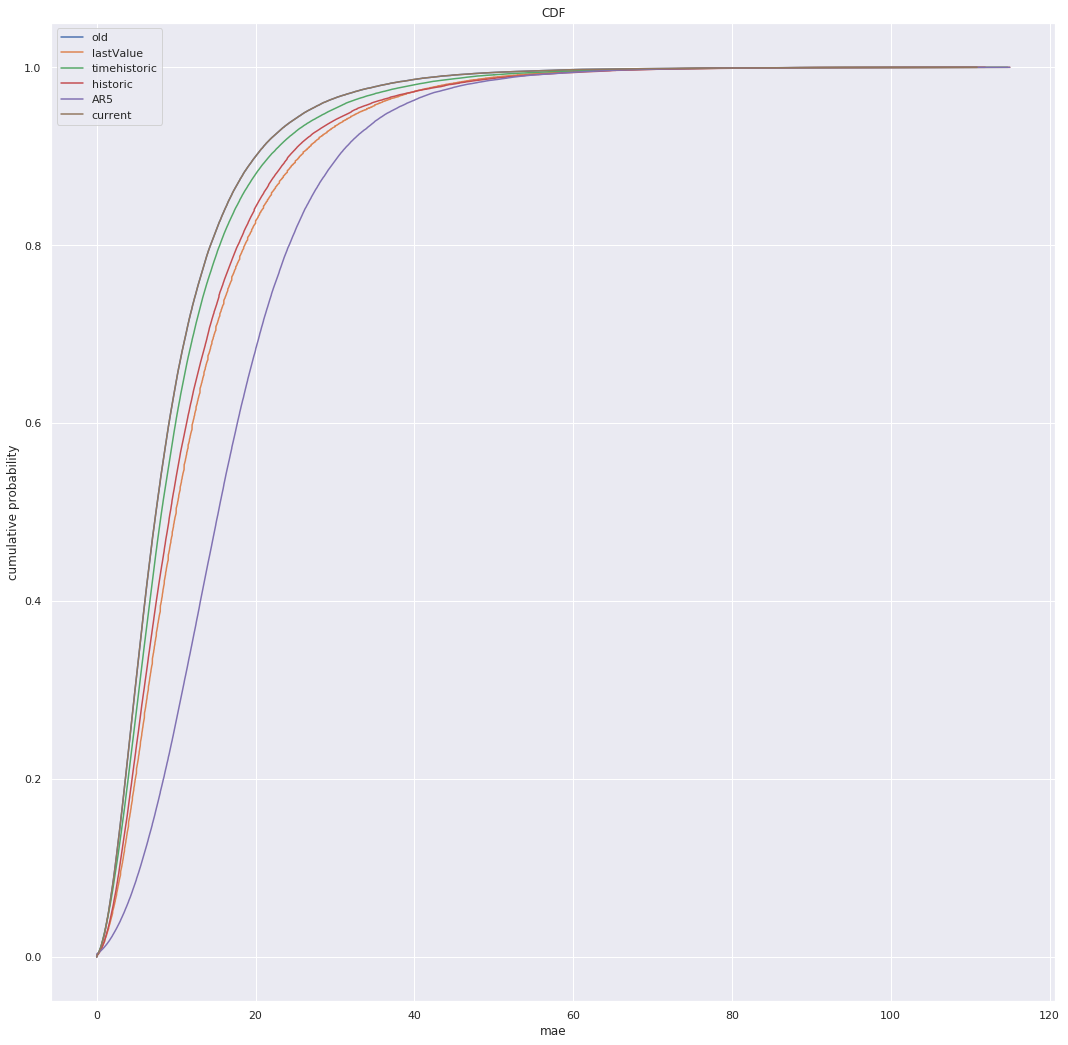

In [76]:
plt.figure(figsize=(18,18))
oldModelPlotting.cdfPlot(error_type="mae",label="old",plot_lines=False)
lastValue_model_plotting.cdfPlot(error_type="mae",label="lastValue",plot_lines=False)
timehistoric_model_plotting.cdfPlot(error_type="mae",label="timehistoric",plot_lines=False)
historic_model_plotting.cdfPlot(error_type="mae",label="historic",plot_lines=False)
AR5_model_plotting.cdfPlot(error_type="mae",label="AR5",plot_lines=False)
model_plotting.cdfPlot(error_type="mae",label="current",plot_lines=False)

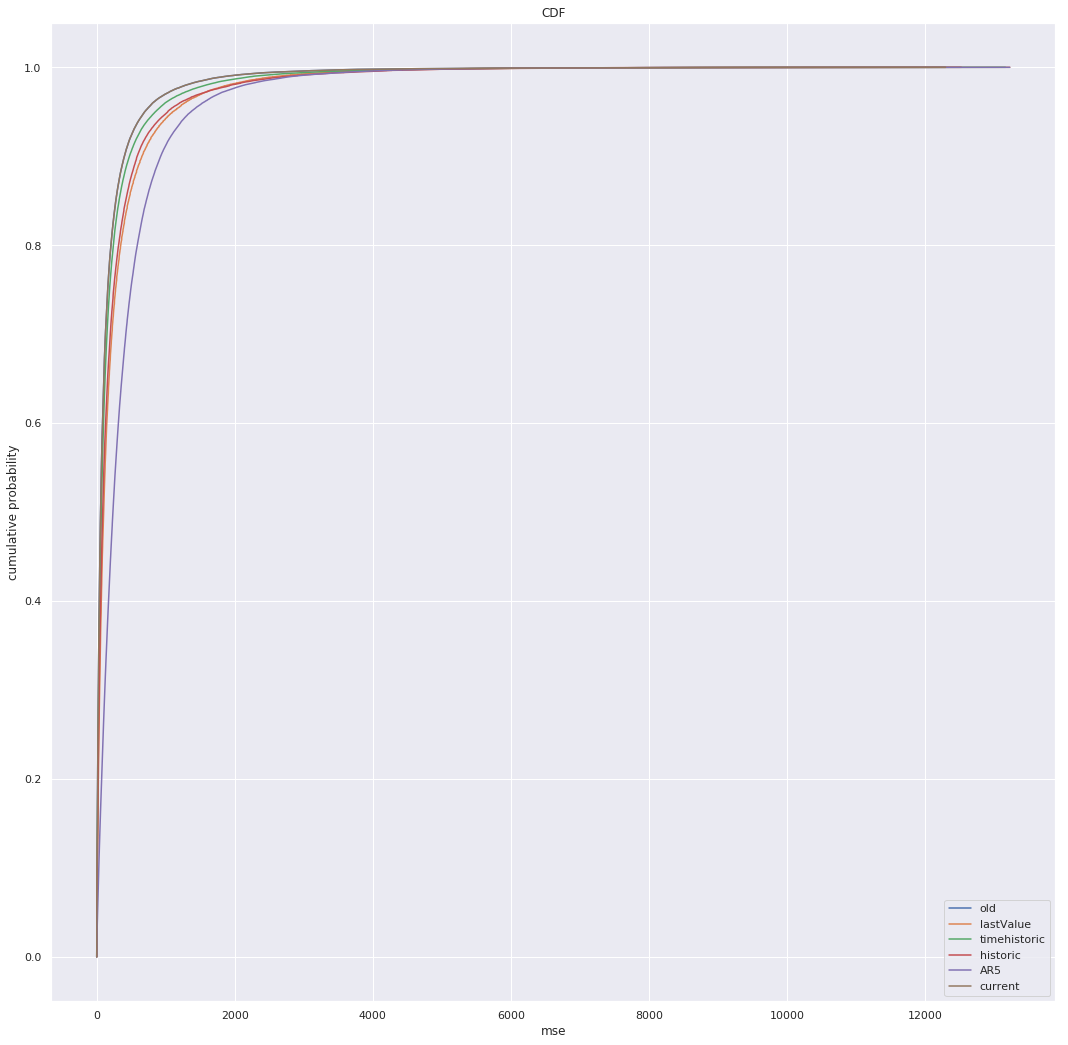

In [77]:
plt.figure(figsize=(18,18))
oldModelPlotting.cdfPlot(error_type="mse",label="old",plot_lines=False)
lastValue_model_plotting.cdfPlot(error_type="mse",label="lastValue",plot_lines=False)
timehistoric_model_plotting.cdfPlot(error_type="mse",label="timehistoric",plot_lines=False)
historic_model_plotting.cdfPlot(error_type="mse",label="historic",plot_lines=False)
AR5_model_plotting.cdfPlot(error_type="mse",label="AR5",plot_lines=False)
model_plotting.cdfPlot(error_type="mse",label="current",plot_lines=False)


In [136]:
oldModelPlotting = model_plotting

In [352]:
oldMLPModel

In [338]:
oldLstmModel

In [263]:
balancedLstmsPlotting

In [193]:
unbalancedLstmsPlotting

In [209]:
unbalancedConvsPlotting

In [224]:
balancedConvsPlotting

In [237]:
balancedConvsTanhPlotting

In [251]:
unbalancedConvsTanhPlotting

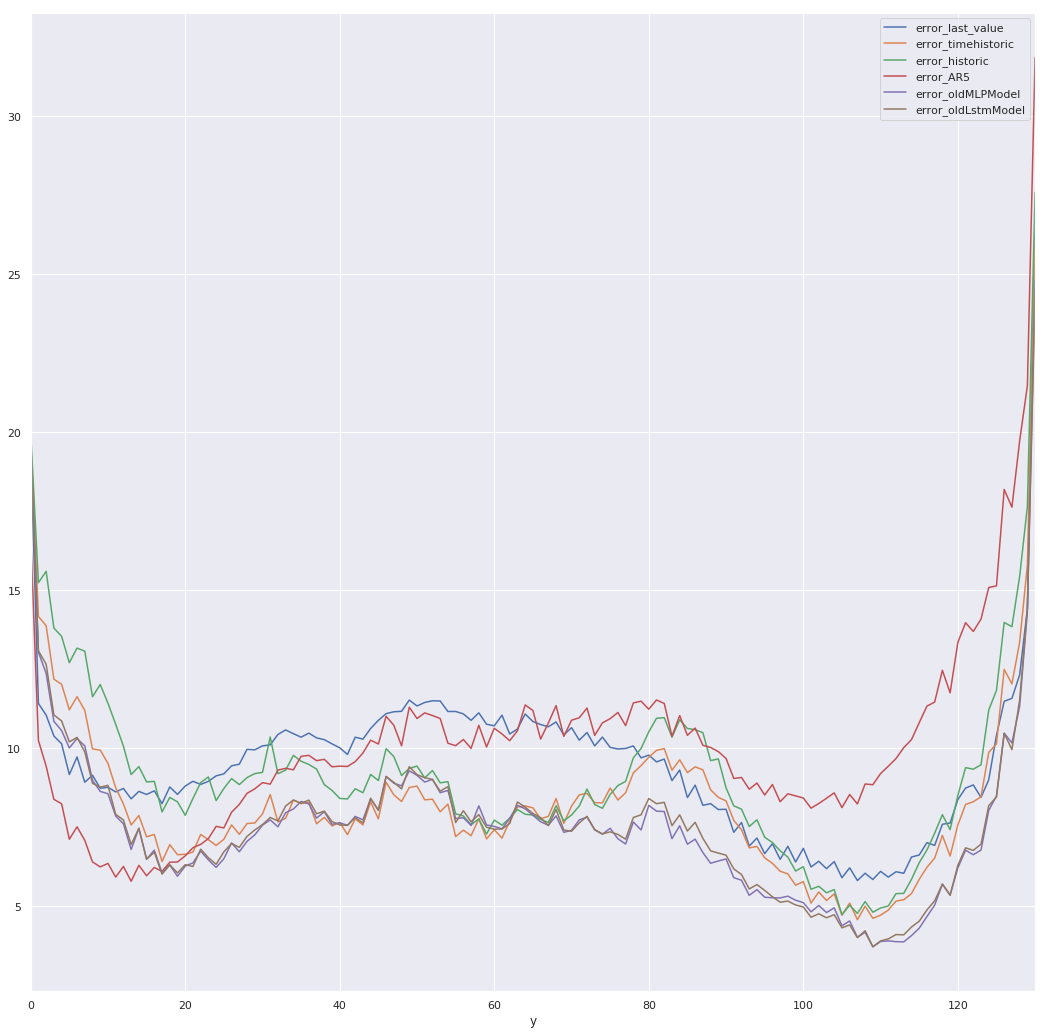

In [353]:
fig = plt.figure(figsize=(18,18))
ax=plt.gca()
lastValue_model_plotting.plotDiscreteSpeedError(ax,"last_value")
timehistoric_model_plotting.plotDiscreteSpeedError(ax,"timehistoric")
historic_model_plotting.plotDiscreteSpeedError(ax,"historic")
AR5_model_plotting.plotDiscreteSpeedError(ax,"AR5")
oldMLPModel.plotDiscreteSpeedError(ax,"oldMLPModel")
oldLstmModel.plotDiscreteSpeedError(ax,"oldLstmModel")

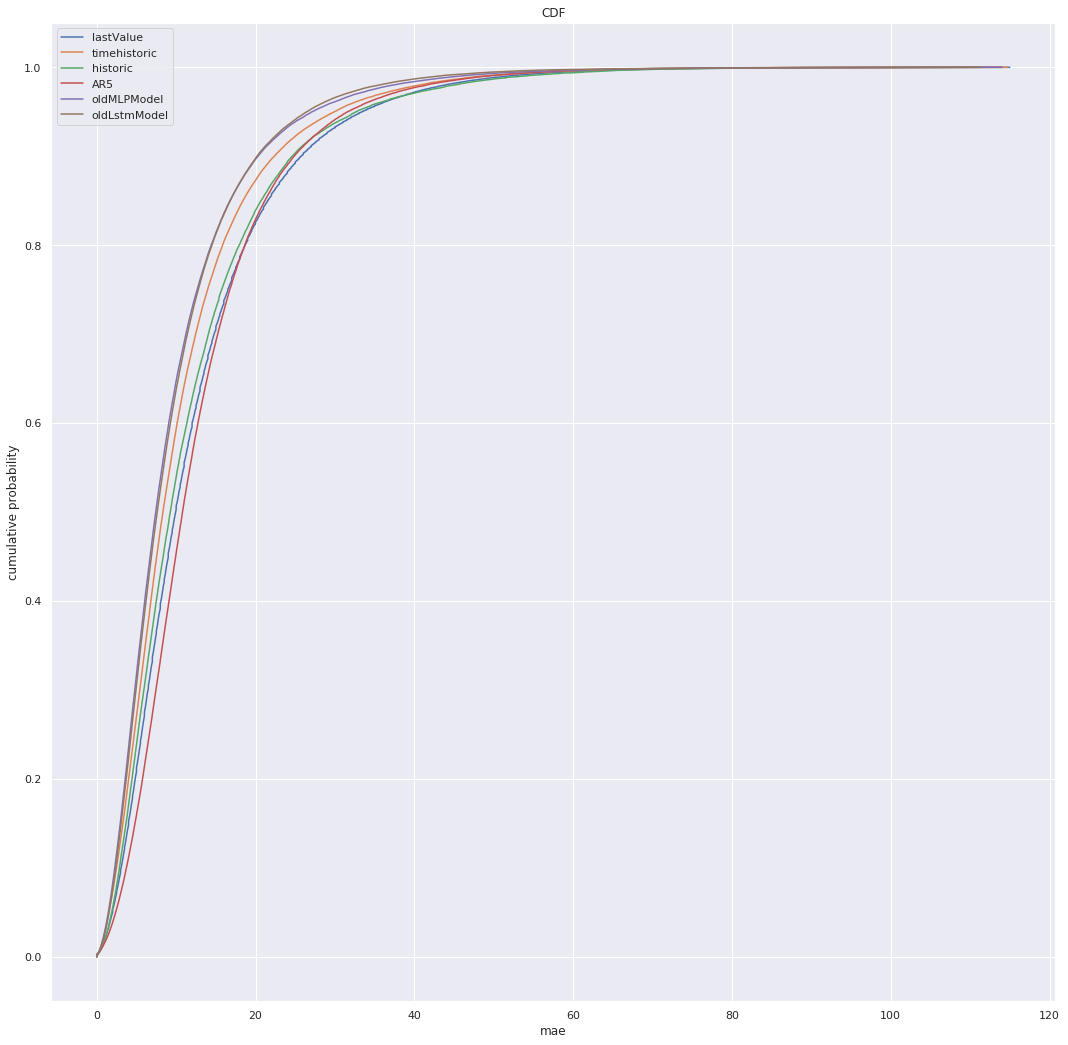

In [359]:
fig= plt.figure(figsize=(18,18))
lastValue_model_plotting.cdfPlot(error_type="mae",label="lastValue",plot_lines=False)
timehistoric_model_plotting.cdfPlot(error_type="mae",label="timehistoric",plot_lines=False)
historic_model_plotting.cdfPlot(error_type="mae",label="historic",plot_lines=False)
AR5_model_plotting.cdfPlot(error_type="mae",label="AR5",plot_lines=False)
oldMLPModel.cdfPlot(error_type="mae",label="oldMLPModel",plot_lines=False)
oldLstmModel.cdfPlot(error_type="mae",label="oldLstmModel",plot_lines=False)


In [360]:
fig.savefig("old mae.png",dpi=300,bbox_inches='tight')

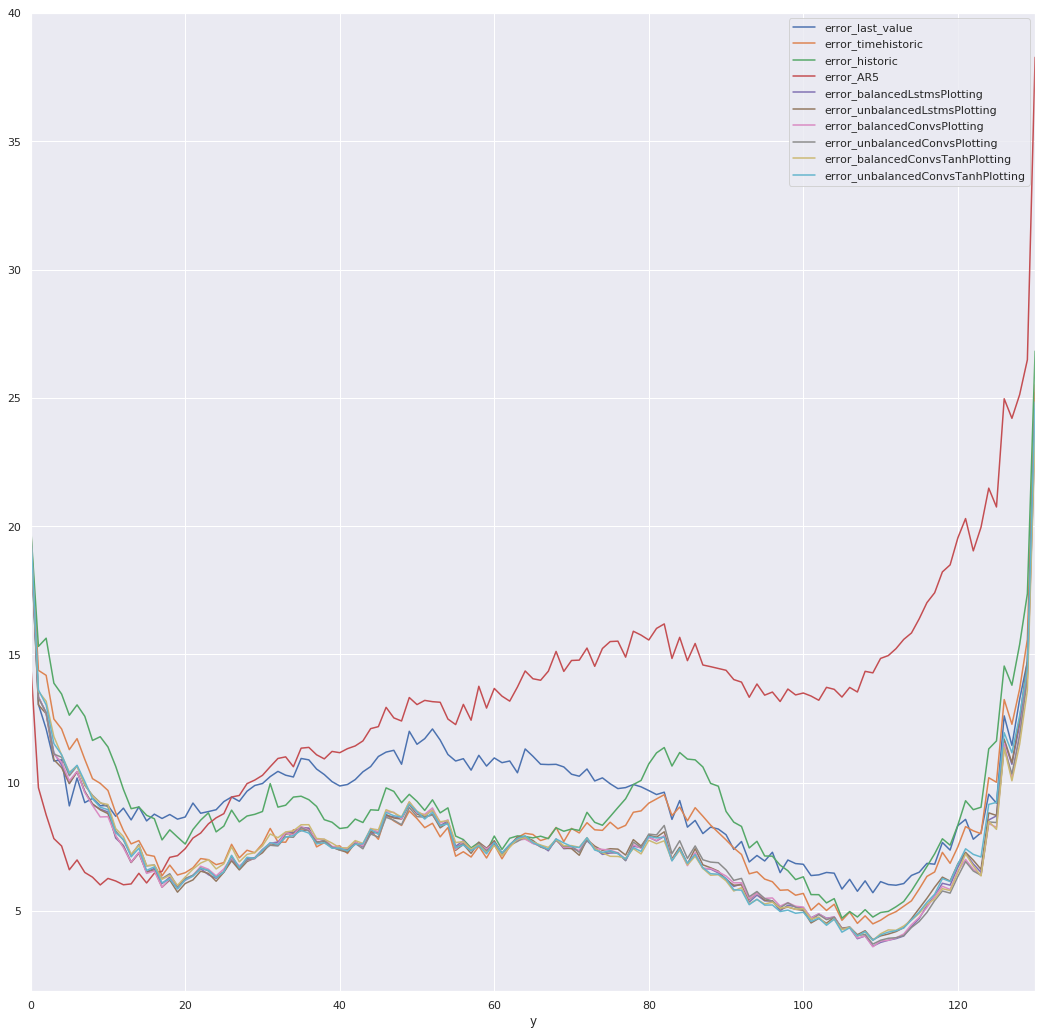

In [292]:
fig = plt.figure(figsize=(18,18))
ax=plt.gca()
lastValue_model_plotting.plotDiscreteSpeedError(ax,"last_value")
timehistoric_model_plotting.plotDiscreteSpeedError(ax,"timehistoric")
historic_model_plotting.plotDiscreteSpeedError(ax,"historic")
AR5_model_plotting.plotDiscreteSpeedError(ax,"AR5")
balancedLstmsPlotting.plotDiscreteSpeedError(ax,"balancedLstmsPlotting")
unbalancedLstmsPlotting.plotDiscreteSpeedError(ax,"unbalancedLstmsPlotting")
balancedConvsPlotting.plotDiscreteSpeedError(ax,"balancedConvsPlotting")
unbalancedConvsPlotting.plotDiscreteSpeedError(ax,"unbalancedConvsPlotting")
balancedConvsTanhPlotting.plotDiscreteSpeedError(ax,"balancedConvsTanhPlotting")
unbalancedConvsTanhPlotting.plotDiscreteSpeedError(ax,"unbalancedConvsTanhPlotting")

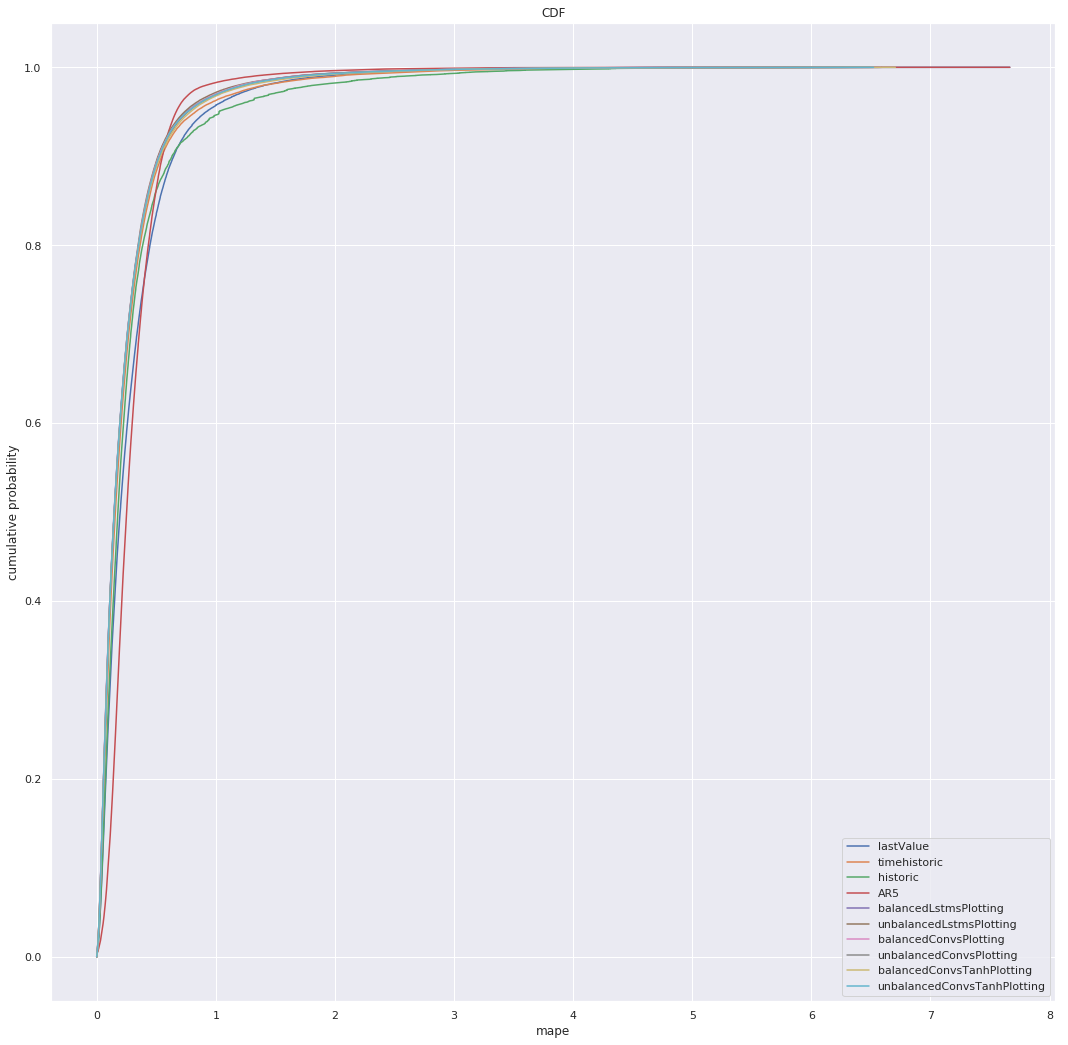

In [298]:
fig= plt.figure(figsize=(18,18))
lastValue_model_plotting.cdfPlot(error_type="mape",label="lastValue",plot_lines=False)
timehistoric_model_plotting.cdfPlot(error_type="mape",label="timehistoric",plot_lines=False)
historic_model_plotting.cdfPlot(error_type="mape",label="historic",plot_lines=False)
AR5_model_plotting.cdfPlot(error_type="mape",label="AR5",plot_lines=False)
balancedLstmsPlotting.cdfPlot(error_type="mape",label="balancedLstmsPlotting",plot_lines=False)
unbalancedLstmsPlotting.cdfPlot(error_type="mape",label="unbalancedLstmsPlotting",plot_lines=False)
balancedConvsPlotting.cdfPlot(error_type="mape",label="balancedConvsPlotting",plot_lines=False)
unbalancedConvsPlotting.cdfPlot(error_type="mape",label="unbalancedConvsPlotting",plot_lines=False)
balancedConvsTanhPlotting.cdfPlot(error_type="mape",label="balancedConvsTanhPlotting",plot_lines=False)
unbalancedConvsTanhPlotting.cdfPlot(error_type="mape",label="unbalancedConvsTanhPlotting",plot_lines=False)


In [302]:
plotmodels = [lastValue_model_plotting,
timehistoric_model_plotting,
historic_model_plotting,
AR5_model_plotting,
balancedLstmsPlotting,
unbalancedLstmsPlotting,
balancedConvsPlotting,
unbalancedConvsPlotting,
balancedConvsTanhPlotting,
unbalancedConvsTanhPlotting]

In [306]:
plotmodelsnames = ["lastValue",
"timehistoric",
"historic_model",
"AR5_model",
"balancedLstms",
"unbalancedLstms",
"balancedConvs",
"unbalancedConvs",
"balancedConvsTanh",
"unbalancedConvsTanh"]

In [361]:
oldmodels = [lastValue_model_plotting,
timehistoric_model_plotting,
historic_model_plotting,
AR5_model_plotting,
oldMLPModel,
oldLstmModel]

In [362]:
oldplotmodelsnames = ["lastValue",
"timehistoric",
"historic_model",
"AR5_model",
"oldMLPModel",
"oldLstmModel"]

In [308]:
def fastmse(x,y):
    return np.mean((x-y)**2)
def fastmae(x,y):
    return np.mean(abs(x-y))

def fastmseclip(x,y):
    return np.mean((x.clip(15)-y.clip(15))**2)
def fastmaeclip(x,y):
    return np.mean(abs(x.clip(15)-y.clip(15)))

def fastmape(x,y):
    return np.mean(abs(x.clip(15)-y.clip(15))/y.clip(15))

In [310]:
mderrorsDF = pd.DataFrame([[fastmse(mopl.y.flatten(),mopl.preds.flatten()) for mopl in plotmodels],
              [fastmae(mopl.y.flatten(),mopl.preds.flatten()) for mopl in plotmodels],
              [fastmseclip(mopl.y.flatten(),mopl.preds.flatten()) for mopl in plotmodels],
              [fastmaeclip(mopl.y.flatten(),mopl.preds.flatten()) for mopl in plotmodels],
              [fastmape(mopl.y.flatten(),mopl.preds.flatten()) for mopl in plotmodels],
             ],
             index=["mse","mae","mse clipped 15","mae clipped 15","mape clipped 15"],
             columns=plotmodelsnames)

In [363]:
oldmderrorsDF = pd.DataFrame([[fastmse(mopl.y.flatten(),mopl.preds.flatten()) for mopl in oldmodels],
              [fastmae(mopl.y.flatten(),mopl.preds.flatten()) for mopl in oldmodels],
              [fastmseclip(mopl.y.flatten(),mopl.preds.flatten()) for mopl in oldmodels],
              [fastmaeclip(mopl.y.flatten(),mopl.preds.flatten()) for mopl in oldmodels],
              [fastmape(mopl.y.flatten(),mopl.preds.flatten()) for mopl in oldmodels],
             ],
             index=["mse","mae","mse clipped 15","mae clipped 15","mape clipped 15"],
             columns=oldplotmodelsnames)

In [367]:
mderrorsDF

lastValue  timehistoric  historic_model   AR5_model  \
mse              170.966158    125.792684      154.198234  259.513076   
mae                9.056511      7.488598        8.418172   12.492965   
mse clipped 15   153.021107    115.444291      142.931156  242.956597   
mae clipped 15     8.372592      7.005848        7.928984   11.740412   
mape clipped 15    0.190567      0.150936        0.163642    0.284323   

                 balancedLstms  unbalancedLstms  balancedConvs  \
mse                 106.232870       106.004554     106.596316   
mae                   6.904965         6.917705       6.920774   
mse clipped 15       96.401422        96.208488      96.884404   
mae clipped 15        6.419529         6.432246       6.438970   
mape clipped 15       0.140700         0.141426       0.140838   

                 unbalancedConvs  balancedConvsTanh  unbalancedConvsTanh  
mse                   107.511904         108.890417           107.229664  
mae                     6.946412           6.978004             6.922060  
mse clipped 15         97.533374          98.969404            97.270537  
mae clipped 15          6.463635           6.496082             6.437642  
mape clipped 15         0.140528           0.139690             0.140294

In [368]:
oldmderrorsDF

lastValue  timehistoric  historic_model   AR5_model  \
mse              171.783094    130.368080      157.461870  164.763807   
mae                9.066898      7.645517        8.476700    9.393122   
mse clipped 15   153.648691    119.878712      145.875606  152.950033   
mae clipped 15     8.358320      7.151668        7.976548    8.788914   
mape clipped 15    0.193744      0.154589        0.163960    0.209354   

                 oldMLPModel  oldLstmModel  
mse               110.691191    107.851197  
mae                 6.964830      7.031223  
mse clipped 15    100.749765     97.841252  
mae clipped 15      6.474662      6.530444  
mape clipped 15     0.142001      0.142369

In [49]:
from mongoConnection import *

In [50]:
segments = OsmProcessing.getSegments(osmWays)

In [51]:
segments = OsmProcessing.setOneWay(segments)

In [77]:
fmap = Plotting.getFoliumMap()

In [78]:
lst =list(map(lambda x :int(x[:-2]),data_cleaner.mergedIndex[data_cleaner.mergedIndex.isin(speedDF.index)].index))

In [79]:
layer = Plotting.plotRoads(segments[segments.index.isin(lst)],fmap=fmap)

(1555,) (1555,) 1555


In [80]:
layer.add_to(fmap)

In [81]:
fmap.save("primary_map.html")

In [131]:
onedaydata = coyoteData.find({"time":{"$gte":1547560800,"$lt":1547578800}})

In [ ]:
onedaydata = list(onedaydata)

In [137]:
onedayDF=pd.DataFrame(onedaydata)

In [138]:
onedayDF

INSEE_iris_code                       _id country  heading  \
0                  N/A  5c3e19872958a73b66b51594      FR      312   
1                  N/A  5c3e16632958a73b669c682b      FR      132   
2                  N/A  5c3e23572958a73b66f981a4      FR      132   
3                  N/A  5c3df10f2958a73b6681e29a      FR      132   
4                  N/A  5c3e12c52958a73b667f5ef1      FR      312   
5                  N/A  5c3e254e2958a73b66055d28      FR      132   
6                  N/A  5c3e09632958a73b6633ff73      FR      132   
7                  N/A  5c3e134a2958a73b66839301      FR      312   
8                  N/A  5c3dfef12958a73b66e32f1b      FR      132   
9                  N/A  5c3e16642958a73b669c7171      FR      133   
10                 N/A  5c3df0ca2958a73b66801f94      FR      134   
11                 N/A  5c3df5f12958a73b66a2bc17      FR      312   
12                 N/A  5c3e154d2958a73b6693c109      FR      312   
13                 N/A  5c3dfde22958a73b66db5df2      FR      133   
14                 N/A  5c3e16452958a73b669b7be5      FR      132   
15                 N/A  5c3e07032958a73b662133d9      FR      132   
16                 N/A  5c3e09fb2958a73b6638c26f      FR      132   
17                 N/A  5c3dea0c2958a73b66550696      FR      134   
18                 N/A  5c3e1e4d2958a73b66d82e6c      FR      132   
19                 N/A  5c3df3cb2958a73b6694234b      FR      132   
20                 N/A  5c3e00252958a73b66ec3c58      FR      132   
21                 N/A  5c3e1fd52958a73b66e2b4d8      FR      133   
22                 N/A  5c3e16742958a73b669cf41a      FR      133   
23                 N/A  5c3e0a5d2958a73b663bcb0c      FR      132   
24                 N/A  5c3e286b2958a73b6616b0a3      FR      133   
25                 N/A  5c3e1b1f2958a73b66c1310e      FR      133   
26                 N/A  5c3e1e982958a73b66da3672      FR      311   
27                 N/A  5c3e2a882958a73b66213349      FR      312   
28                 N/A  5c3de9482958a73b66502990      FR      311   
29                 N/A  5c3df6a82958a73b66a7aa8e      FR      311   
...                ...                       ...     ...      ...   
474383             N/A  5c3e127a2958a73b667d0d60      FR      188   
474384             N/A  5c3e12982958a73b667dfd82      FR      188   
474385             N/A  5c3e12d72958a73b667ff1f4      FR      188   
474386             N/A  5c3e12f52958a73b6680e24b      FR      188   
474387             N/A  5c3e12b82958a73b667ef929      FR      188   
474388             N/A  5c3e13322958a73b6682ca8b      FR      188   
474389             N/A  5c3e13512958a73b6683c625      FR      188   
474390             N/A  5c3e12282958a73b667a74fb      FR      112   
474391             N/A  5c3e14cc2958a73b668fb3b8      FR      277   
474392             N/A  5c3e14cc2958a73b668fb270      FR      279   
474393             N/A  5c3e12012958a73b66793d35      FR       99   
474394             N/A  5c3e13142958a73b6681dad4      FR      188   
474395             N/A  5c3e15782958a73b66951afd      FR      215   
474396             N/A  5c3dfe302958a73b66dd98db      FR       33   
474397             N/A  5c3de8a32958a73b664c1631      FR       34   
474398             N/A  5c3e153b2958a73b66932ab9      FR      253   
474399             N/A  5c3de8c12958a73b664cd9b2      FR       74   
474400             N/A  5c3dfe4f2958a73b66de7eea      FR       74   
474401             N/A  5c3e155a2958a73b669422a9      FR      254   
474402             N/A  5c3dfe6d2958a73b66df5cde      FR       67   
474403             N/A  5c3e11e22958a73b667843b9      FR      182   
474404             N/A  5c3e14e92958a73b66909d93      FR        7   
474405             N/A  5c3e15092958a73b66919b2d      FR      327   
474406             N/A  5c3e11c42958a73b66775254      FR      156   
474407             N/A  5c3e11bc2958a73b66771084      FR      242   
474408             N/A  5c3e151d2958a73b66923d07      FR      242   
47440